In [ ]:
!nvidia-smi

In [ ]:
%matplotlib inline
import os
import torch
from torch import autograd
import torch.nn.functional as F
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
import wandb
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from fairseq.data import (
    data_utils,
    StripTokenDataset,
)
from fairseq.trainer import Trainer
from fairseq import tasks
from data import ExtractedFeaturesDataset, RandomInputDataset
import math
import fairseq
from models.wav2vec_u import Wav2vec_U as w2vu
from models.wav2dyn_gpt import Wav2vec_U as w2vuindy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import itertools

In [2]:
seed = 11
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

config = {
    "cp_w2d": '/multirun/2023-05-28/18-30-44/0/w2v-indy-phn_en-phn_en_2023-05-28_18:29:15_2/checkpoint_best.pt',
#     "cp_w2d": '/multirun/2023-05-21/22-10-47/0/w2v-indy-phn_en-phn_en_2023-05-21_22:08:44_1/checkpoint_best.pt',
    "cp_w2p": '/multirun/2023-05-04/07-33-47/0/w2v2_2023-05-04_07:33:02_2/checkpoint_best.pt',
    "device": 'cuda',
    "batch_size": 160
}

model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([config["cp_w2p"]], strict=True)
wav2phn = model[0]
wav2phn.cuda()
wav2phn.eval()

for p in wav2phn.parameters():
    p.requires_grad = False

In [3]:
def load_cfg_task(cp):
    state = fairseq.checkpoint_utils.load_checkpoint_to_cpu(cp)
    cfg = state["cfg"]
    task = tasks.setup_task(cfg.task)
    task.load_state_dict(state["task_state"])
    model = task.build_model(cfg.model)
    return cfg, task

In [4]:
def select_non_padding_elements(input_tensor, mask):
    # Get the dimensions
    B, T, D = input_tensor.size()
    # Reshape the input tensor and mask to combine the batch and time dimensions
    reshaped_input = input_tensor.view(-1, D)
    reshaped_mask = mask.contiguous().view(-1)
    # Get the indices of non-padding elements
    indices = torch.nonzero(~reshaped_mask).squeeze()
    # Select the non-padding elements from the reshaped input tensor
    selected_elements = reshaped_input[indices]
    # Reshape the selected elements tensor to the original format
    N = selected_elements.size(0)
    selected_elements = selected_elements.view(N, D)
    return selected_elements

In [5]:
data_path = '/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/'
text_data = '/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-txt/phones'

# model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([config["cp_w2d"]], strict=False)
# wav2dyn = model[0]
# wav2dyn.cuda()
cfg, task = load_cfg_task(config["cp_w2d"])
wav2dyn = task.build_model(cfg.model)
criterion = task.build_criterion(cfg.criterion)
trainer = Trainer(cfg, task, wav2dyn, criterion, None)

cfg.checkpoint['restore_file'] = config["cp_w2d"]

extra_sate, epoch_itr = fairseq.checkpoint_utils.load_checkpoint(
    cfg.checkpoint,
    trainer,
    disable_iterator_cache=task.has_sharded_data("train")
)


target_dict = task._target_dictionary

LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M
LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


2023-05-29 16:34:39 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- ref_lm.lm_head.weight
2023-05-29 16:34:39 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.transformer.wte.weight
2023-05-29 16:34:39 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.lm_head.weight
2023-05-29 16:34:39 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wpe.weight <- gen_lm.transformer.wpe.weight
2023-05-29 16:34:39 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.ln_1.weight <- gen_lm.transformer.h.0.ln_1.weight
2023-05-29 16:34:39 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.weight <- gen_lm.transformer.h.0.attn.c_attn.weight
2023-05-29 16:34:39 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.attn.c_proj.bias
202

2023-05-29 16:34:40 | INFO | fairseq.trainer | loading train data for epoch 445
2023-05-29 16:34:50 | INFO | fairseq.data.extracted_features_dataset | loaded 28539, skipped 0 samples
2023-05-29 16:34:50 | INFO | fairseq.tasks.unpaired_audio_text | split train has unpaired text? True
2023-05-29 16:34:50 | INFO | fairseq.data.data_utils | loaded 2,400,103 examples from: /home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-txt/phones/train


In [6]:
def prepare_dataset(split):
    has_unpaired_text = os.path.exists(os.path.join(text_data, f"{split}.idx"))
    dataset = ExtractedFeaturesDataset(
        path=data_path,
        split=split,
        min_length=3,
        max_length=256,
        labels=None if has_unpaired_text else 'phn',
        label_dict=target_dict,
        shuffle=True,
        aux_target_postfix='km'
    )
    if has_unpaired_text:
        text_dataset = data_utils.load_indexed_dataset(os.path.join(text_data, split), target_dict)
        text_dataset = StripTokenDataset(text_dataset, target_dict.eos())
        dataset = RandomInputDataset(
            dataset,
            text_dataset,
            ["random_label"],
            add_to_input=True,
            pad_idx=target_dict.pad(),
        )
    return dataset

def get_batch_iterator(split, epoch):
    batch_iterator = task.get_batch_iterator(
        dataset=train_data if split == 'train' else val_data,
        max_sentences=config["batch_size"],
        ignore_invalid_inputs=True,
        seed=0 + epoch,
        num_workers=2,
        epoch=epoch
    )
    dummy_batch = batch_iterator.first_batch
    itr = batch_iterator.next_epoch_itr(shuffle=True if split == 'train' else False)
    return itr

train_data = prepare_dataset('train')
val_data = prepare_dataset('valid')

2023-05-29 16:35:02 | INFO | data.extracted_features_dataset | loaded 2641, skipped 0 samples
2023-05-29 16:35:03 | INFO | fairseq.data.data_utils | loaded 2,400,103 examples from: /home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-txt/phones/train
2023-05-29 16:35:03 | INFO | data.extracted_features_dataset | auxaliry target for valid missing
2023-05-29 16:35:03 | INFO | data.extracted_features_dataset | loaded 1703, skipped 0 samples


# What happens with the loss of the trained w2d discriminator if fed w2p posteriograms?

In [7]:
results = []
epoch = 1
train_itr = get_batch_iterator('train', epoch)
features, padding_mask, _, random_label = next(train_itr)["net_input"].values()  # fetch the very first batchs
models = {
    "w2d": wav2dyn,
    "w2p": wav2phn
}
for model in models.values():
    model.eval()
    
i = 0
while True:
    with torch.no_grad():
        for n, model in models.items():
            posteriograms, padding_mask_post = model(features.to(config["device"]), padding_mask.to(config["device"]), random_label.to(config["device"]), dense_x_only=True).values()
            c_embeddings, c_logits, predictograms, c_entropy = wav2dyn.gen_lm(posteriograms)
            disc_score = F.sigmoid(wav2dyn.discriminator(predictograms, padding_mask_post))
            for b in range(posteriograms.size(0)):
                results.append({
                    "posteriograms": posteriograms[b].cpu().numpy(),
                    "padding_mask_post": padding_mask_post[b].cpu().numpy(),
                    "c_embeddings": c_embeddings[b].cpu().numpy(),
                    "predictograms": predictograms[b].cpu().numpy(),
                    "c_entropy": c_entropy[b].cpu().numpy(),
                    "disc_score": disc_score[b].item(),
                    "model": n,
                    "sample_idx": i,
                    "batch_idx": b
                })
        i += 1
    try:
        features, padding_mask, _, random_label = next(train_itr)["net_input"].values()
    except StopIteration:
        break
df = pd.DataFrame(results)

<AxesSubplot: xlabel='disc_score', ylabel='Count'>

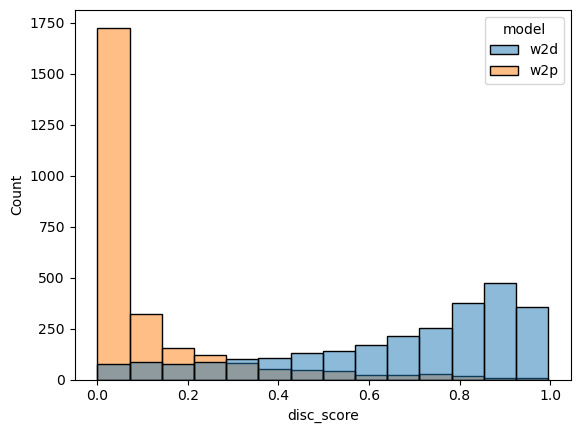

In [8]:
sns.histplot(data=df, x="disc_score", hue="model")

<SIL> M AH N Z HH AA ER T L UW ER <SIL>
<SIL> W IH SH W <SIL> D ER L IY <SIL> F EH T ER Z <SIL>
<SIL> Y UW AY W ER T UW <SIL> UW W OW T UW F AO R CH AH ER <SIL>
<SIL> S AH G W AW T AH V TH AO TH R AY EY SH EY T UW
<SIL> W AY Z F AO R <SIL> EY M <SIL> AH L ER Z <SIL>
<SIL> DH AE AY SH AH T <SIL> S IH S T UH D M AY S AA ER Z <SIL>
<SIL> IH N <SIL> AW T UW <SIL> G IH N AH DH Z <SIL>
<SIL> IH N <SIL> AH ER D L IY IH N <SIL> AH L ER Z <SIL>
<SIL> AH S IH S EY SH IH NG AH SH UH D IH T W UH D B AH V AE T EY M AY S IH S ER Z <SIL>
<SIL> B IH HH AE T DH IH NG T UW S IH K T UW P EY TH IH NG AW NG T TH W IH SH <SIL>
<SIL> AH DH AE T <SIL> HH ER R AY ER T UW L UH T M OW T L ER <SIL>
<SIL> Y UW T EY SH AH N Z T UW ER <SIL>


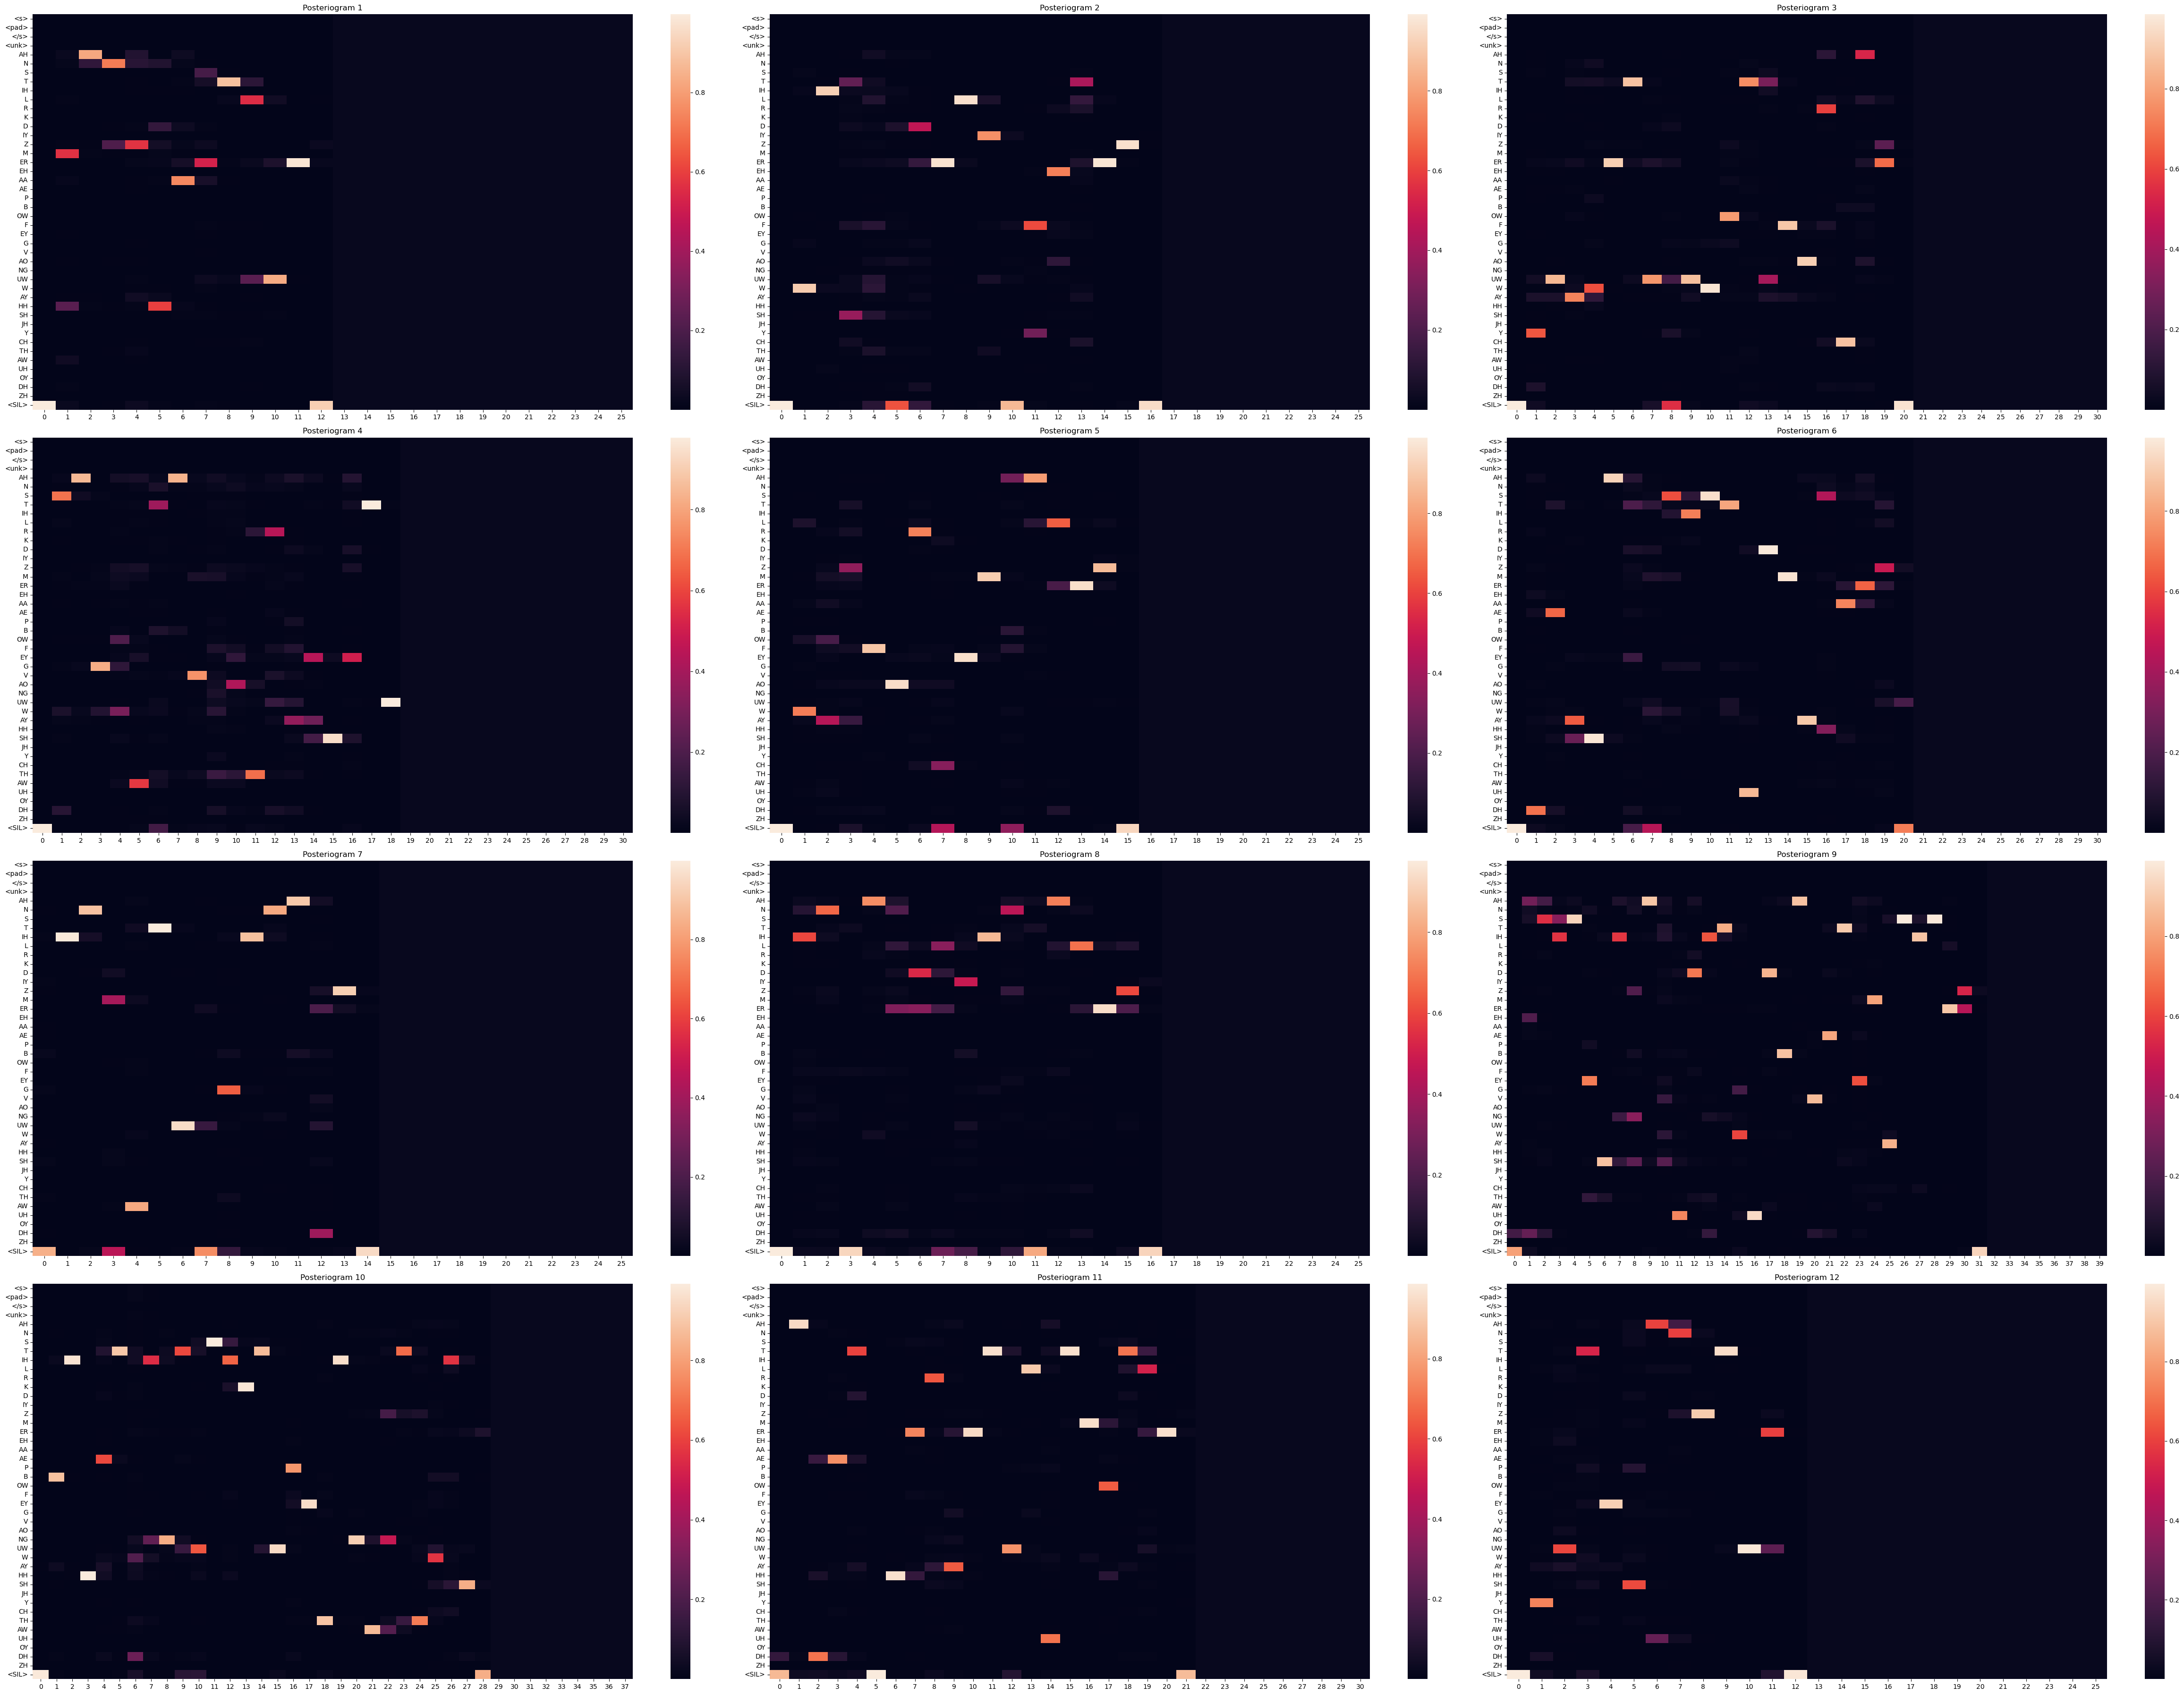

In [9]:
# Filter rows for the "w2d" model and sort by "disc_score" in ascending order
w2d_rows = df[df.model == "w2d"].sort_values("disc_score")

# Get the 12 best posteriograms
best_posteriograms = w2d_rows.head(12)["posteriograms"]

plt.figure(figsize=(48, 36))

# Iterate over the 12 best posteriograms and plot them in a 3x4 grid
for i, posteriogram in enumerate(best_posteriograms):
    plt.subplot(4, 3, i+1)
    sns.heatmap(posteriogram.T, yticklabels=task.target_dictionary.symbols)
#     print(f"{i + 1}. [{w2d_rows.iloc[i].disc_score}]\n", task.target_dictionary.string(posteriogram.argmax(-1)))
    print(task.target_dictionary.string(posteriogram.argmax(-1)))
    plt.title(f"Posteriogram {i+1}")

plt.tight_layout()
plt.show()

We'll compare the best sequences generated from w2d with its corresponding transcript according to w2p:

In [10]:
for i in w2d_rows.head(12).index:
    row = w2d_rows.head(12).loc[i]
    sample_idx = row.sample_idx
    batch_idx = row.batch_idx
    w2p_post = df[(df.model == "w2p") & (df.sample_idx == sample_idx) & (df.batch_idx == batch_idx)].posteriograms.to_numpy()
    print(task.target_dictionary.string(w2p_post[0].argmax(-1)))

<SIL> AY T EH N IY N AY N S <SIL>
<SIL> K AY TH IH NG K S AH N T S L AA R AA T AH S <SIL>
<SIL> DH AY OW M AY N D AH <SIL> AY M G L AE Y AO R AW AH V IH T <SIL>
<SIL> DH AY DH AH <SIL> R EH K AH S T AW ER <SIL> AH <SIL> R AY V <SIL>
<SIL> DH AY G EH T <SIL> AW T <SIL> HH L JH AH N D S <SIL>
<SIL> AY AH N D W IH L AH R AY V <SIL> DH EH R <SIL> L EY T UW N AY <SIL>
<SIL> AY S EY N T JH EY M Z AH S EH V AH N D <SIL>
<SIL> K S IH L V IY AH N S <SIL> S EH L V IY AH S <SIL>
<SIL> AH N D EH N DH AH F IH SH AH L EH T F AH M L AH N D AH D W AA Z R EH D T UW DH EH M S <SIL>
<SIL> AY SH IY <SIL> W UH D F AY N D <SIL> DH AE T <SIL> IH N D S P AY ER R IH NG <SIL>
<SIL> IH N W IH CH <SIL> N EH V ER <SIL> M AE N D <SIL> K UH D W EH L S <SIL>
<SIL> DH AY <SIL> R IH P L AY D <SIL>


We'll get a confusion matrix using w2p posteriograms as labels

In [11]:
epoch = 1
train_itr = get_batch_iterator('train', epoch)
features, padding_mask, _, random_label = next(train_itr)["net_input"].values()  # fetch the very first batchs
targets = []
preds = []
wav2dyn.eval()
while True:
    with torch.no_grad():
        posteriograms, padding_mask_post = wav2phn(features.to(config["device"]), padding_mask.to(config["device"]), random_label.to(config["device"]), dense_x_only=True, segment=False).values()
        unpadded_posteriograms = select_non_padding_elements(posteriograms, padding_mask_post)
        targets += unpadded_posteriograms.argmax(-1).tolist()
        posteriograms, padding_mask_post = wav2dyn(features.to(config["device"]), padding_mask.to(config["device"]), random_label.to(config["device"]), dense_x_only=True, segment=False).values()
        unpadded_posteriograms = select_non_padding_elements(posteriograms, padding_mask_post)
        preds += unpadded_posteriograms.argmax(-1).tolist()
    try:
        features, padding_mask, _, random_label = next(train_itr)["net_input"].values()
    except StopIteration:
        break

In [12]:
labels = [
    '<SIL>','AH', 'N', 'T', 'IH', 'D', 'S', 'R', 'L', 'IY', 'DH', 'EH', 'M', 'AE', 'Z', 'K', 'ER',
    'HH', 'W', 'UW', 'AA', 'V', 'AY', 'F', 'P', 'B', 'AO', 'EY', 'OW', 'NG', 'G', 'SH', 'Y',
    'AW', 'CH', 'UH', 'TH', 'JH', 'OY', 'ZH', '<s>', '<pad>', '</s>', '<unk>'
]

symbols = task.target_dictionary.symbols
sorted_indices = sorted(range(len(labels)), key=lambda x: labels.index(symbols[x]))
print(sorted_indices)

[43, 4, 5, 7, 8, 12, 6, 10, 9, 13, 41, 17, 15, 19, 14, 11, 16, 32, 30, 29, 18, 26, 31, 23, 20, 21, 27, 24, 22, 28, 25, 33, 35, 38, 36, 39, 37, 34, 40, 42, 0, 1, 2, 3]


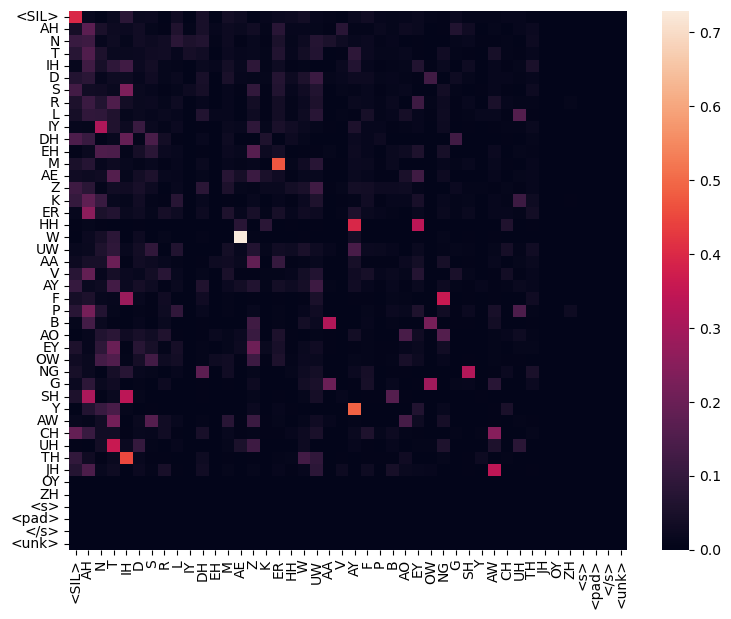

F1-score: 0.028657225208345533


In [13]:
conf_matrix = confusion_matrix(targets, preds, labels=sorted_indices)
plt.figure(figsize=(9, 7))
sns.heatmap(conf_matrix / (np.sum(conf_matrix, 1, keepdims=True) + 1e-20), 
            yticklabels=labels, xticklabels=labels)
plt.show()
print(f"F1-score: {f1_score(targets, preds, average='macro')}")

# Analysis of the minima

In [14]:
train_config = {
    "out_dir": 'w2d_minima_analysis',
    "learning_rate_g": 0.00005,
    "beta1_g": 0.5,
    "beta2_g": 0.98,
    "eps_g": 1e-6,
    "weight_decay_g": 0,
    "learning_rate_d": 0.0003,
    "beta1_d": 0.5,
    "beta2_d": 0.98,
    "eps_d": 1e-6,
    "weight_decay_d": 0.0001,
    "batch_size": 160,
    "log_interval": 10,
    "max_iters": 1000,
    "lr_decay_iters": 1000,
    "warmup_iters_g": 0,
    "min_lr_g": 0.00005,
    "warmup_iters_d": 0,
    "min_lr_d": 0.0003,
    "grad_clip": 5.0,
    "enabled_losses": ["dense_g", "dense_d", "token_d"]# , "grad_pen", "code_pen", "smoothness"]
}

config.update(train_config)

## Who is pushing in the wrong direction?

In [16]:
only_dense_g = False

for best in [True, False]:
    for oracle in ([True, False] if not only_dense_g else [False]):
        for switch_turns in ([True, False] if oracle else [False] if only_dense_g else [True]):
            ckpt_dir = os.path.dirname(config["cp_w2d"])
            ckpt_path = os.path.join(ckpt_dir, 'checkpoint_best.pt' if best else 'checkpoint_last.pt')
            wandb.init(
                project='w2v-u-indy',
                name=f"[{'BEST' if best else 'LAST'}]"
                     f"[{'ORACLE&DISC' if (oracle and switch_turns) else 'ORACLE' if oracle else 'NORMAL'}]"
                     f"{'[ONLY-G]' if only_dense_g else ''}"
                     "minima-analysis",
                entity='indy-lis',
                config={'cp': ckpt_path, 'oracle': oracle}
            )

            # --------------------------------------------------------------------------------------------------------
            cfg, task = load_cfg_task(config["cp_w2d"])
            wav2dyn = task.build_model(cfg.model)
            criterion = task.build_criterion(cfg.criterion)
            trainer = Trainer(cfg, task, wav2dyn, criterion, None)
            cfg.checkpoint['restore_file'] = config["cp_w2d"]
            extra_sate, epoch_itr = fairseq.checkpoint_utils.load_checkpoint(
                cfg.checkpoint,
                trainer,
                disable_iterator_cache=task.has_sharded_data("train")
            )
            wav2dyn.train()
            # --------------------------------------------------------------------------------------------------------
            config["max_iters"] = 100
            config["log_interval"] = 1
            loss_weights = []
            epoch = 1
            train_itr = epoch_itr._get_iterator_for_epoch(epoch_itr.epoch, shuffle=True)
            features, padding_mask, aux_target, random_label = next(train_itr)["net_input"].values()  # fetch the very first batchs
            iter_num = 0

            gen_losses = ["loss_dense_g"] if only_dense_g else ["code_pen", "loss_dense_g", "mmi", "smoothness"]
            disc_losses = ["grad_pen", "loss_dense_d", "loss_token_d"]

            while True:
                res = wav2dyn(features.to(config["device"]), 
                              padding_mask.to(config["device"]), 
                              random_label.to(config["device"]),
                              aux_target=aux_target.to(config["device"]), debugging=True)
                posteriograms = select_non_padding_elements(res["posteriogram"].contiguous(), 
                                                            res["posteriogram_mask"].contiguous())
                target_post, _ = wav2phn(features.to(config["device"]), padding_mask.to(config["device"]), random_label.to(config["device"]), dense_x_only=True, segment=False).values()
                target_post = select_non_padding_elements(target_post, res["posteriogram_mask"])
                target_post = target_post.argmax(-1)
                losses = res["losses"]
                losses["oracle"] = F.cross_entropy(posteriograms, target_post)

                scaled_losses = {}
                for lk, p in losses.items():
                    try:
                        coef = 1.0 if len(loss_weights) == 0 else loss_weights[lk]
                    except KeyError:
                        logger.error(
                            f"weight for loss {lk} is not in loss_weights ({loss_weights})"
                        )
                        raise
                    if coef != 0 and p is not None:
                        scaled_losses[lk] = coef * p.float()

                turn = wav2dyn.get_groups_for_update(wav2dyn.update_num) if switch_turns else "generator"
                wandb.log(dict(scaled_losses, **{"turn": float(turn =="generator")}))

                if turn == 'generator':
                    loss = losses["oracle"] if oracle else sum(scaled_losses[key] for key in scaled_losses.keys() if key in gen_losses)
                else:
                    loss = sum(scaled_losses[key] for key in scaled_losses.keys() if key in disc_losses)
                trainer.optimizer.optimizers[turn].backward(loss)
                trainer.clip_grad_norm(cfg.optimization.clip_norm)
                trainer.optimizer.optimizers[turn].step()
                trainer.zero_grad()
                if iter_num % config["log_interval"] == 0:
                    log_str = f"iter {iter_num + 1}, {turn}'s turn\nLoss: {loss:.4f}"
                    for lk, lv in scaled_losses.items():
                        log_str += f"\n\t{lk}:{lv.item(): .4f}"
                    print(log_str)
                iter_num += 1
                wav2dyn.update_num += 1
                if iter_num > config["max_iters"]:
                    break
                try:
                    features, padding_mask, aux_target, random_label = next(train_itr)["net_input"].values()
                except StopIteration:
                    epoch += 1
                    train_itr = epoch_itr.next_epoch_itr(shuffle=True)
                    features, padding_mask, aux_target, random_label = next(train_itr)["net_input"].values()
            wandb.finish()

code_pen,▁
dense_d,▁
dense_g,▁
grad_pen,▁
mmi,▁
oracle,▁
smoothness,▁
token_d,▁
turn,▁
code_pen,54.98075
dense_d,4.87372


2023-05-29 11:31:27 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- ref_lm.lm_head.weight
2023-05-29 11:31:27 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.transformer.wte.weight
2023-05-29 11:31:27 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.lm_head.weight
2023-05-29 11:31:27 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wpe.weight <- gen_lm.transformer.wpe.weight
2023-05-29 11:31:27 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.ln_1.weight <- gen_lm.transformer.h.0.ln_1.weight
2023-05-29 11:31:27 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.weight <- gen_lm.transformer.h.0.attn.c_attn.weight
2023-05-29 11:31:27 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.attn.c_proj.bias
202

LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M
LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


2023-05-29 11:31:27 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.mlp.c_proj.bias
2023-05-29 11:31:27 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.2.attn.c_attn.bias
2023-05-29 11:31:27 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.2.attn.c_proj.bias
2023-05-29 11:31:27 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.2.mlp.c_fc.bias
2023-05-29 11:31:27 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.2.mlp.c_proj.bias
2023-05-29 11:31:27 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.lm_head.bias
2023-05-29 11:31:27 | INFO | fairseq.trainer | detected shared parameter: ref_lm.tr

iter 1, generator's turn
Loss: 6.9430
	grad_pen: 5.3327
	code_pen: 53.6978
	smoothness: 273.3175
	mmi: 79.3423
	dense_d: 5.0509
	dense_g: 620.1292
	token_d: 7.1312
	oracle: 6.9430
iter 2, discriminator's turn
Loss: 13.7160
	grad_pen: 13.7160
	code_pen: 49.1689
	smoothness: 253.3151
	mmi: 79.3284
	dense_d: 4.1578
	dense_g: 638.5575
	token_d: 6.0975
	oracle: 6.0834
iter 3, generator's turn
Loss: 6.0884
	grad_pen: 8.6903
	code_pen: 49.2856
	smoothness: 253.0426
	mmi: 80.6056
	dense_d: 3.2972
	dense_g: 669.5649
	token_d: 8.6866
	oracle: 6.0884
iter 4, discriminator's turn
Loss: 11.9619
	grad_pen: 11.9619
	code_pen: 47.3059
	smoothness: 236.0414
	mmi: 81.1752
	dense_d: 1.9384
	dense_g: 748.5828
	token_d: 7.2901
	oracle: 4.9702
iter 5, generator's turn
Loss: 4.9838
	grad_pen: 6.6091
	code_pen: 42.8661
	smoothness: 230.3364
	mmi: 78.4592
	dense_d: 2.0771
	dense_g: 756.4080
	token_d: 7.0932
	oracle: 4.9838
iter 6, discriminator's turn
Loss: 5.4611
	grad_pen: 5.4611
	code_pen: 42.1141
	smoothne

iter 46, discriminator's turn
Loss: 8.8170
	grad_pen: 8.8170
	code_pen: 74.2007
	smoothness: 708.3069
	mmi: 89.9819
	dense_d: 77.5965
	dense_g: 226.9008
	token_d: 27.6004
	oracle: 0.2353
iter 47, generator's turn
Loss: 0.2369
	grad_pen: 16.3730
	code_pen: 89.5561
	smoothness: 748.6718
	mmi: 98.1014
	dense_d: 73.8392
	dense_g: 215.3917
	token_d: 26.0387
	oracle: 0.2369
iter 48, discriminator's turn
Loss: 14.9627
	grad_pen: 14.9627
	code_pen: 92.4359
	smoothness: 754.2099
	mmi: 95.4597
	dense_d: 71.4918
	dense_g: 224.5333
	token_d: 18.3008
	oracle: 0.2275
iter 49, generator's turn
Loss: 0.2292
	grad_pen: 4.8738
	code_pen: 83.6834
	smoothness: 726.6735
	mmi: 92.8696
	dense_d: 83.6943
	dense_g: 213.4341
	token_d: 25.2315
	oracle: 0.2292
iter 50, discriminator's turn
Loss: 18.7298
	grad_pen: 18.7298
	code_pen: 89.0751
	smoothness: 789.6418
	mmi: 98.4512
	dense_d: 82.8836
	dense_g: 201.2838
	token_d: 24.2689
	oracle: 0.2250
iter 51, generator's turn
Loss: 0.2240
	grad_pen: 6.7614
	code_pen: 

iter 91, generator's turn
Loss: 0.1682
	grad_pen: 2.2629
	code_pen: 74.9316
	smoothness: 978.5663
	mmi: 98.5698
	dense_d: 79.8650
	dense_g: 200.3304
	token_d: 36.9272
	oracle: 0.1682
iter 92, discriminator's turn
Loss: 7.9382
	grad_pen: 7.9382
	code_pen: 90.3072
	smoothness: 1029.4230
	mmi: 106.2807
	dense_d: 80.4780
	dense_g: 215.3672
	token_d: 31.2598
	oracle: 0.1709
iter 93, generator's turn
Loss: 0.1640
	grad_pen: 2.9374
	code_pen: 88.1383
	smoothness: 991.5244
	mmi: 101.1897
	dense_d: 75.6473
	dense_g: 211.4383
	token_d: 36.1409
	oracle: 0.1640
iter 94, discriminator's turn
Loss: 3.1324
	grad_pen: 3.1324
	code_pen: 82.6125
	smoothness: 1028.4462
	mmi: 102.4590
	dense_d: 77.3792
	dense_g: 215.4219
	token_d: 30.2432
	oracle: 0.1576
iter 95, generator's turn
Loss: 0.1562
	grad_pen: 5.4606
	code_pen: 90.1788
	smoothness: 1037.6843
	mmi: 103.0076
	dense_d: 62.8299
	dense_g: 237.5469
	token_d: 43.7291
	oracle: 0.1562
iter 96, discriminator's turn
Loss: 7.8748
	grad_pen: 7.8748
	code_pen

code_pen,▃▂▂▂▁▂▁▅▄▆▆▇▆▇▇▇▇▆█▇▇█▇▇▆▇█▆▆▆█▇█▇▇▆▇█▇█
dense_d,▁▁▁▁▁▁▁▂▃▅▆▅▆▆▆█▇▆▆▇▇▆▇▆▆▆▇▇▆▇▇▆▆▇█▇▇▆▆▇
dense_g,▅▅▇███▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_pen,▁▁▁▁▂▁█▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▁▁▁▁▁
mmi,▂▃▃▄▃▃▁▅▃▄▅▇▅▆▆▆▇▆▆▅▇▇█▇▇▆▇▇▅▆▇▆█▆▇▇▇▇▇█
oracle,█▇▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
smoothness,▁▁▁▁▁▁▁▂▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇█▇███
token_d,▁▁▂▂▂▃▃▃▂▁▂▂▃▄▅▃▄▆▅▄▄▅▅▄▄▅▆▆▄▆▅▆▅▅▅▅▇██▆
turn,██▁▁██▁▁█▁▁██▁▁█▁▁██▁▁██▁██▁▁██▁██▁▁██▁█
code_pen,92.93269
dense_d,75.75742


2023-05-29 11:32:43 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- ref_lm.lm_head.weight
2023-05-29 11:32:43 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.transformer.wte.weight
2023-05-29 11:32:43 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.lm_head.weight
2023-05-29 11:32:43 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wpe.weight <- gen_lm.transformer.wpe.weight
2023-05-29 11:32:43 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.ln_1.weight <- gen_lm.transformer.h.0.ln_1.weight


LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M
LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


2023-05-29 11:32:43 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.weight <- gen_lm.transformer.h.0.attn.c_attn.weight
2023-05-29 11:32:43 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.attn.c_proj.bias
2023-05-29 11:32:43 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.mlp.c_fc.bias
2023-05-29 11:32:43 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.mlp.c_proj.bias
2023-05-29 11:32:43 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.attn.c_attn.bias
2023-05-29 11:32:43 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.attn.c_proj.bias
2023-05-29 11:32:43 | INFO | fairseq.trainer | detected sh

iter 1, generator's turn
Loss: 6.9490
	grad_pen: 6.9347
	code_pen: 51.3404
	smoothness: 273.6075
	mmi: 79.1616
	dense_d: 4.3084
	dense_g: 618.5514
	token_d: 6.7831
	oracle: 6.9490
iter 2, generator's turn
Loss: 6.0821
	grad_pen: 17.7294
	code_pen: 49.9865
	smoothness: 253.2533
	mmi: 79.1636
	dense_d: 4.8177
	dense_g: 635.1425
	token_d: 5.5569
	oracle: 6.0821
iter 3, generator's turn
Loss: 4.9798
	grad_pen: 5.4488
	code_pen: 43.0427
	smoothness: 234.4796
	mmi: 81.1020
	dense_d: 3.8880
	dense_g: 697.1601
	token_d: 6.7008
	oracle: 4.9798
iter 4, generator's turn
Loss: 3.9152
	grad_pen: 6.1874
	code_pen: 40.2708
	smoothness: 224.7380
	mmi: 82.1652
	dense_d: 0.8884
	dense_g: 860.7476
	token_d: 5.5690
	oracle: 3.9152
iter 5, generator's turn
Loss: 2.9768
	grad_pen: 5.8443
	code_pen: 38.7060
	smoothness: 217.9100
	mmi: 80.5783
	dense_d: 0.6501
	dense_g: 970.6741
	token_d: 8.6657
	oracle: 2.9768
iter 6, generator's turn
Loss: 2.2355
	grad_pen: 9.5398
	code_pen: 43.7201
	smoothness: 230.7536
	m

iter 46, generator's turn
Loss: 0.1657
	grad_pen: 16.9375
	code_pen: 75.1231
	smoothness: 931.2458
	mmi: 93.9696
	dense_d: 243.3242
	dense_g: 83.7829
	token_d: 4.1323
	oracle: 0.1657
iter 47, generator's turn
Loss: 0.1686
	grad_pen: 6.6480
	code_pen: 90.0470
	smoothness: 997.1384
	mmi: 102.3982
	dense_d: 233.3172
	dense_g: 85.1790
	token_d: 5.5779
	oracle: 0.1686
iter 48, generator's turn
Loss: 0.1647
	grad_pen: 7.4277
	code_pen: 92.5273
	smoothness: 992.1892
	mmi: 99.6403
	dense_d: 226.5231
	dense_g: 79.2980
	token_d: 7.8516
	oracle: 0.1647
iter 49, generator's turn
Loss: 0.1651
	grad_pen: 7.8200
	code_pen: 85.2816
	smoothness: 964.3865
	mmi: 97.1769
	dense_d: 237.3634
	dense_g: 91.1694
	token_d: 5.8147
	oracle: 0.1651
iter 50, generator's turn
Loss: 0.1610
	grad_pen: 10.6081
	code_pen: 91.7832
	smoothness: 1038.1033
	mmi: 102.5077
	dense_d: 245.6135
	dense_g: 78.1148
	token_d: 5.4120
	oracle: 0.1610
iter 51, generator's turn
Loss: 0.1580
	grad_pen: 10.6577
	code_pen: 82.0986
	smoothn

iter 91, generator's turn
Loss: 0.1223
	grad_pen: 24.5542
	code_pen: 75.5970
	smoothness: 1281.6089
	mmi: 104.2911
	dense_d: 256.7841
	dense_g: 66.7027
	token_d: 6.3071
	oracle: 0.1223
iter 92, generator's turn
Loss: 0.1266
	grad_pen: 10.9028
	code_pen: 90.2589
	smoothness: 1345.9810
	mmi: 111.7756
	dense_d: 234.6723
	dense_g: 87.1360
	token_d: 6.8882
	oracle: 0.1266
iter 93, generator's turn
Loss: 0.1243
	grad_pen: 11.6099
	code_pen: 86.5513
	smoothness: 1301.1635
	mmi: 106.7995
	dense_d: 256.8496
	dense_g: 69.9182
	token_d: 4.9508
	oracle: 0.1243
iter 94, generator's turn
Loss: 0.1201
	grad_pen: 10.8015
	code_pen: 82.8063
	smoothness: 1340.0298
	mmi: 108.1112
	dense_d: 242.0407
	dense_g: 83.2425
	token_d: 4.7341
	oracle: 0.1201
iter 95, generator's turn
Loss: 0.1178
	grad_pen: 8.5432
	code_pen: 87.7612
	smoothness: 1354.5178
	mmi: 108.7001
	dense_d: 273.3565
	dense_g: 70.4903
	token_d: 7.3116
	oracle: 0.1178
iter 96, generator's turn
Loss: 0.1244
	grad_pen: 23.2403
	code_pen: 79.6932

code_pen,▂▁▁▃▅▆▂▇▅▆▆█▆▇▆▇▇▆▇▇▇█▇▇▆▇█▆▅▆█▇▇▇▆▆▇▇▇█
dense_d,▁▁▁▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇█▇███▇
dense_g,▅▆█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_pen,▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▃▁▁▁▂▁▁▂▁▁▁▁
mmi,▁▂▂▄▃▄▁▅▃▄▅▇▅▆▅▆▆▆▆▅▇▇█▇▇▆▇▆▅▆▇▆█▆▇▇▇▇▇█
oracle,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
smoothness,▁▁▁▁▂▂▂▃▃▄▄▅▅▅▅▅▆▆▆▅▆▆▆▇▆▆▇▇▆▇▇▇▇▇▇█▇███
token_d,▆▆▇▄▂▄▂▄▂▂▃▇▇▅▂▇▁▆▄▅▄▅▆▆▅▃▁▄▃▁█▇▃▄▇▆▃▇▆▅
turn,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
code_pen,93.44609
dense_d,251.71777


2023-05-29 11:34:02 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- ref_lm.lm_head.weight
2023-05-29 11:34:02 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.transformer.wte.weight
2023-05-29 11:34:02 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.lm_head.weight
2023-05-29 11:34:02 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wpe.weight <- gen_lm.transformer.wpe.weight
2023-05-29 11:34:02 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.ln_1.weight <- gen_lm.transformer.h.0.ln_1.weight


LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M
LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


2023-05-29 11:34:02 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.weight <- gen_lm.transformer.h.0.attn.c_attn.weight
2023-05-29 11:34:02 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.attn.c_proj.bias
2023-05-29 11:34:02 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.mlp.c_fc.bias
2023-05-29 11:34:02 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.mlp.c_proj.bias
2023-05-29 11:34:02 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.attn.c_attn.bias
2023-05-29 11:34:02 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.attn.c_proj.bias
2023-05-29 11:34:02 | INFO | fairseq.trainer | detected sh

iter 1, generator's turn
Loss: 406.1996
	grad_pen: 5.6757
	code_pen: 53.3800
	smoothness: 273.3613
	mmi: 79.4584
	dense_d: 4.9136
	dense_g: 617.8065
	token_d: 7.4050
	oracle: 6.9618
iter 2, discriminator's turn
Loss: 18.7921
	grad_pen: 18.7921
	code_pen: 42.1890
	smoothness: 243.4378
	mmi: 83.3594
	dense_d: 4.0232
	dense_g: 659.1734
	token_d: 5.6769
	oracle: 6.5731
iter 3, generator's turn
Loss: 371.9200
	grad_pen: 6.7734
	code_pen: 42.7375
	smoothness: 243.6139
	mmi: 85.5686
	dense_d: 4.3700
	dense_g: 677.4637
	token_d: 9.3036
	oracle: 6.5744
iter 4, discriminator's turn
Loss: 8.0545
	grad_pen: 8.0545
	code_pen: 30.4810
	smoothness: 212.7487
	mmi: 88.3422
	dense_d: 1.8877
	dense_g: 785.0131
	token_d: 8.0344
	oracle: 6.1481
iter 5, generator's turn
Loss: 323.7228
	grad_pen: 12.1365
	code_pen: 31.1856
	smoothness: 207.6620
	mmi: 84.8753
	dense_d: 1.6353
	dense_g: 796.3527
	token_d: 8.2222
	oracle: 6.1693
iter 6, discriminator's turn
Loss: 53.3379
	grad_pen: 53.3379
	code_pen: 22.2729
	s

iter 46, discriminator's turn
Loss: 4.3054
	grad_pen: 4.3054
	code_pen: 0.0295
	smoothness: 13.2770
	mmi: 75.6043
	dense_d: 0.3465
	dense_g: 1073.0408
	token_d: 32.6165
	oracle: 3.9098
iter 47, generator's turn
Loss: 97.0079
	grad_pen: 10.1201
	code_pen: 0.0303
	smoothness: 14.1990
	mmi: 82.7786
	dense_d: 0.2373
	dense_g: 1088.5535
	token_d: 38.0753
	oracle: 3.9093
iter 48, discriminator's turn
Loss: 8.4747
	grad_pen: 8.4747
	code_pen: 0.0230
	smoothness: 12.6442
	mmi: 79.2114
	dense_d: 0.2452
	dense_g: 1088.8401
	token_d: 28.9412
	oracle: 3.9000
iter 49, generator's turn
Loss: 89.3106
	grad_pen: 18.7594
	code_pen: 0.0236
	smoothness: 12.2081
	mmi: 77.0790
	dense_d: 0.2060
	dense_g: 1103.8596
	token_d: 28.2704
	oracle: 3.9001
iter 50, discriminator's turn
Loss: 41.7488
	grad_pen: 41.7488
	code_pen: 0.0211
	smoothness: 11.8716
	mmi: 81.5125
	dense_d: 0.2124
	dense_g: 1104.1627
	token_d: 30.4607
	oracle: 3.8881
iter 51, generator's turn
Loss: 94.0407
	grad_pen: 32.4079
	code_pen: 0.0213


iter 91, generator's turn
Loss: 79.2906
	grad_pen: 13.5067
	code_pen: 0.0032
	smoothness: 2.0363
	mmi: 77.2511
	dense_d: 0.2943
	dense_g: 1055.1332
	token_d: 43.6467
	oracle: 3.7992
iter 92, discriminator's turn
Loss: 6.3990
	grad_pen: 6.3990
	code_pen: 0.0041
	smoothness: 1.9882
	mmi: 82.5355
	dense_d: 0.2474
	dense_g: 1069.1340
	token_d: 45.7594
	oracle: 3.8042
iter 93, generator's turn
Loss: 81.1705
	grad_pen: 3.6775
	code_pen: 0.0036
	smoothness: 1.8859
	mmi: 79.2809
	dense_d: 0.3071
	dense_g: 1042.3469
	token_d: 47.6019
	oracle: 3.8028
iter 94, discriminator's turn
Loss: 5.7188
	grad_pen: 5.7188
	code_pen: 0.0036
	smoothness: 1.8074
	mmi: 80.3272
	dense_d: 0.4917
	dense_g: 1023.9951
	token_d: 52.0315
	oracle: 3.7996
iter 95, generator's turn
Loss: 82.6364
	grad_pen: 3.7189
	code_pen: 0.0039
	smoothness: 1.8316
	mmi: 80.8009
	dense_d: 0.4554
	dense_g: 1040.4146
	token_d: 61.0234
	oracle: 3.7995
iter 96, discriminator's turn
Loss: 3.3041
	grad_pen: 3.3041
	code_pen: 0.0033
	smoothne

code_pen,█▇▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dense_d,█▇▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
dense_g,▁▂▅▆▆█▇█▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇
grad_pen,▁▁▇▃▂▃█▄▂▂▁▁▃▃▂▂▂▁▂▃▂▃▂▁▁▃▂▁▃▁▁▁▁▁▆▂▁▁▁▁
mmi,▄▆▆█▅▅▁█▃▃▆▇▅▆▅▆▆▅▅▃▆▅▆▆▅▄▅▄▂▄▅▃▆▃▄▄▄▅▄▅
oracle,█▇▅▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
smoothness,█▇▆▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
token_d,▁▁▂▁▂▃▃▄▃▄▅▄▅▆▅▄▅▆▅▄▄▄▆▆▅▃▅▆█▆▅▅▆▅▆▅▆█▇▆
turn,██▁▁██▁▁█▁▁██▁▁█▁▁██▁▁██▁██▁▁██▁██▁▁██▁█
code_pen,0.0035
dense_d,0.72563


2023-05-29 11:35:22 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- ref_lm.lm_head.weight
2023-05-29 11:35:22 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.transformer.wte.weight
2023-05-29 11:35:22 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.lm_head.weight
2023-05-29 11:35:22 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wpe.weight <- gen_lm.transformer.wpe.weight
2023-05-29 11:35:22 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.ln_1.weight <- gen_lm.transformer.h.0.ln_1.weight
2023-05-29 11:35:22 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.weight <- gen_lm.transformer.h.0.attn.c_attn.weight
2023-05-29 11:35:22 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.attn.c_proj.bias
202

LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M
LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


2023-05-29 11:35:22 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.attn.c_attn.bias
2023-05-29 11:35:22 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.attn.c_proj.bias
2023-05-29 11:35:22 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.mlp.c_fc.bias
2023-05-29 11:35:22 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.mlp.c_proj.bias
2023-05-29 11:35:22 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.2.attn.c_attn.bias
2023-05-29 11:35:22 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.2.attn.c_proj.bias
2023-05-29 11:35:22 | INFO | fairseq.trainer | detected shared

iter 1, generator's turn
Loss: 6.9486
	grad_pen: 5.8179
	code_pen: 53.0862
	smoothness: 273.0415
	mmi: 79.2540
	dense_d: 4.5907
	dense_g: 609.7190
	token_d: 5.5517
	oracle: 6.9486
iter 2, discriminator's turn
Loss: 12.6481
	grad_pen: 12.6481
	code_pen: 48.2648
	smoothness: 253.7591
	mmi: 79.0946
	dense_d: 4.1756
	dense_g: 638.7784
	token_d: 7.0465
	oracle: 6.0920
iter 3, generator's turn
Loss: 6.0785
	grad_pen: 10.2086
	code_pen: 48.2720
	smoothness: 252.8642
	mmi: 80.5435
	dense_d: 3.6372
	dense_g: 675.0778
	token_d: 9.9388
	oracle: 6.0785
iter 4, discriminator's turn
Loss: 11.2170
	grad_pen: 11.2170
	code_pen: 47.5139
	smoothness: 236.0036
	mmi: 81.0938
	dense_d: 1.9775
	dense_g: 757.4891
	token_d: 7.7863
	oracle: 4.9684
iter 5, generator's turn
Loss: 4.9804
	grad_pen: 6.4222
	code_pen: 42.2151
	smoothness: 230.2856
	mmi: 78.2532
	dense_d: 2.2218
	dense_g: 743.4158
	token_d: 11.4020
	oracle: 4.9804
iter 6, discriminator's turn
Loss: 5.3368
	grad_pen: 5.3368
	code_pen: 42.5372
	smooth

iter 46, discriminator's turn
Loss: 5.3364
	grad_pen: 5.3364
	code_pen: 74.2287
	smoothness: 707.3118
	mmi: 90.2664
	dense_d: 82.6378
	dense_g: 226.8213
	token_d: 20.6873
	oracle: 0.2344
iter 47, generator's turn
Loss: 0.2376
	grad_pen: 16.4644
	code_pen: 87.2924
	smoothness: 749.6677
	mmi: 98.2581
	dense_d: 76.1160
	dense_g: 218.0007
	token_d: 25.9140
	oracle: 0.2376
iter 48, discriminator's turn
Loss: 22.1060
	grad_pen: 22.1060
	code_pen: 92.7595
	smoothness: 754.4056
	mmi: 95.5065
	dense_d: 72.6014
	dense_g: 217.8277
	token_d: 24.8255
	oracle: 0.2310
iter 49, generator's turn
Loss: 0.2286
	grad_pen: 6.2796
	code_pen: 83.8611
	smoothness: 726.7492
	mmi: 92.8936
	dense_d: 85.4836
	dense_g: 215.7928
	token_d: 22.1039
	oracle: 0.2286
iter 50, discriminator's turn
Loss: 17.6457
	grad_pen: 17.6457
	code_pen: 87.3360
	smoothness: 789.1074
	mmi: 98.2819
	dense_d: 84.4085
	dense_g: 200.6481
	token_d: 24.0835
	oracle: 0.2248
iter 51, generator's turn
Loss: 0.2246
	grad_pen: 7.9378
	code_pen: 

iter 91, generator's turn
Loss: 0.1676
	grad_pen: 3.9507
	code_pen: 76.1523
	smoothness: 979.2010
	mmi: 98.6130
	dense_d: 79.7943
	dense_g: 199.8785
	token_d: 34.8324
	oracle: 0.1676
iter 92, discriminator's turn
Loss: 3.5453
	grad_pen: 3.5453
	code_pen: 90.1243
	smoothness: 1030.2684
	mmi: 106.0319
	dense_d: 73.9865
	dense_g: 224.8967
	token_d: 30.8269
	oracle: 0.1725
iter 93, generator's turn
Loss: 0.1632
	grad_pen: 5.5106
	code_pen: 85.3080
	smoothness: 991.7230
	mmi: 101.2066
	dense_d: 68.4599
	dense_g: 220.2702
	token_d: 34.1982
	oracle: 0.1632
iter 94, discriminator's turn
Loss: 4.9505
	grad_pen: 4.9505
	code_pen: 82.3482
	smoothness: 1028.4045
	mmi: 102.4270
	dense_d: 71.6538
	dense_g: 229.6331
	token_d: 32.6581
	oracle: 0.1582
iter 95, generator's turn
Loss: 0.1541
	grad_pen: 3.1263
	code_pen: 88.1436
	smoothness: 1038.4397
	mmi: 102.9048
	dense_d: 71.5441
	dense_g: 219.6180
	token_d: 38.8668
	oracle: 0.1541
iter 96, discriminator's turn
Loss: 6.1996
	grad_pen: 6.1996
	code_pen

code_pen,▃▂▂▂▁▂▁▅▄▆▆▇▆▇▆▇▇▆▇▇▇█▇▇▆▇█▆▅▆█▇▇▇▆▆▇▇▇▇
dense_d,▁▁▁▁▁▁▁▂▃▆▆▅▆█▇▇██▇█▇▇▇▆▇▇█▆▇▇▇▆▇▇█▇▆▆▇▇
dense_g,▅▅▇███▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_pen,▁▁▁▁▂▁█▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁
mmi,▂▃▃▄▃▃▁▅▃▄▅▇▅▆▆▆▇▆▆▅▇▇█▇▇▆▇▇▅▆▇▆█▆▇▇▇▇▇█
oracle,█▇▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
smoothness,▁▁▁▁▁▁▁▂▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇█▇███
token_d,▁▂▂▄▂▂▄▂▃▂▃▃▃▄▄▃▄▄▅▄▅▆▆▆▅▆▆▆▇▅▆▇▅▇▆▆▇█▇▇
turn,██▁▁██▁▁█▁▁██▁▁█▁▁██▁▁██▁██▁▁██▁██▁▁██▁█
code_pen,89.41898
dense_d,80.45373


2023-05-29 11:36:47 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- ref_lm.lm_head.weight
2023-05-29 11:36:47 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.transformer.wte.weight
2023-05-29 11:36:47 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.lm_head.weight
2023-05-29 11:36:47 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wpe.weight <- gen_lm.transformer.wpe.weight
2023-05-29 11:36:47 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.ln_1.weight <- gen_lm.transformer.h.0.ln_1.weight


LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M
LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


2023-05-29 11:36:47 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.weight <- gen_lm.transformer.h.0.attn.c_attn.weight
2023-05-29 11:36:47 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.attn.c_proj.bias
2023-05-29 11:36:47 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.mlp.c_fc.bias
2023-05-29 11:36:47 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.mlp.c_proj.bias
2023-05-29 11:36:47 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.attn.c_attn.bias
2023-05-29 11:36:47 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.attn.c_proj.bias
2023-05-29 11:36:47 | INFO | fairseq.trainer | detected sh

iter 1, generator's turn
Loss: 6.9446
	grad_pen: 5.6711
	code_pen: 54.1665
	smoothness: 273.3178
	mmi: 79.3674
	dense_d: 4.8476
	dense_g: 617.4641
	token_d: 3.4552
	oracle: 6.9446
iter 2, generator's turn
Loss: 6.0926
	grad_pen: 12.0233
	code_pen: 48.1096
	smoothness: 253.4848
	mmi: 79.3573
	dense_d: 3.9800
	dense_g: 641.0358
	token_d: 5.7132
	oracle: 6.0926
iter 3, generator's turn
Loss: 4.9836
	grad_pen: 9.6274
	code_pen: 46.3288
	smoothness: 234.7745
	mmi: 81.1867
	dense_d: 3.1444
	dense_g: 690.9802
	token_d: 6.0495
	oracle: 4.9836
iter 4, generator's turn
Loss: 3.9107
	grad_pen: 5.8481
	code_pen: 41.2202
	smoothness: 224.7366
	mmi: 81.9434
	dense_d: 1.0691
	dense_g: 855.9000
	token_d: 7.0692
	oracle: 3.9107
iter 5, generator's turn
Loss: 2.9744
	grad_pen: 7.0414
	code_pen: 39.2396
	smoothness: 217.7574
	mmi: 80.7189
	dense_d: 0.4620
	dense_g: 973.5298
	token_d: 3.6240
	oracle: 2.9744
iter 6, generator's turn
Loss: 2.2303
	grad_pen: 14.2986
	code_pen: 45.6629
	smoothness: 230.3262
	

iter 46, generator's turn
Loss: 0.1656
	grad_pen: 13.2458
	code_pen: 77.2256
	smoothness: 934.8962
	mmi: 94.0656
	dense_d: 239.0097
	dense_g: 79.0883
	token_d: 3.5323
	oracle: 0.1656
iter 47, generator's turn
Loss: 0.1654
	grad_pen: 6.9954
	code_pen: 89.6742
	smoothness: 999.5749
	mmi: 102.3898
	dense_d: 241.9596
	dense_g: 80.5266
	token_d: 4.6136
	oracle: 0.1654
iter 48, generator's turn
Loss: 0.1637
	grad_pen: 7.5610
	code_pen: 91.6354
	smoothness: 994.7631
	mmi: 99.5692
	dense_d: 213.8844
	dense_g: 91.6643
	token_d: 5.1209
	oracle: 0.1637
iter 49, generator's turn
Loss: 0.1647
	grad_pen: 7.5190
	code_pen: 86.5004
	smoothness: 968.5700
	mmi: 97.1140
	dense_d: 247.5220
	dense_g: 86.9935
	token_d: 5.5639
	oracle: 0.1647
iter 50, generator's turn
Loss: 0.1626
	grad_pen: 9.9238
	code_pen: 90.0360
	smoothness: 1041.6024
	mmi: 102.3856
	dense_d: 240.9580
	dense_g: 73.0759
	token_d: 6.3034
	oracle: 0.1626
iter 51, generator's turn
Loss: 0.1591
	grad_pen: 8.3851
	code_pen: 83.6361
	smoothnes

iter 91, generator's turn
Loss: 0.1247
	grad_pen: 21.7863
	code_pen: 76.8827
	smoothness: 1283.9448
	mmi: 104.2178
	dense_d: 249.3696
	dense_g: 72.0638
	token_d: 9.2229
	oracle: 0.1247
iter 92, generator's turn
Loss: 0.1266
	grad_pen: 11.0087
	code_pen: 90.4305
	smoothness: 1346.8464
	mmi: 111.9732
	dense_d: 231.5960
	dense_g: 88.4379
	token_d: 7.0157
	oracle: 0.1266
iter 93, generator's turn
Loss: 0.1243
	grad_pen: 10.4498
	code_pen: 88.0748
	smoothness: 1299.2327
	mmi: 107.0343
	dense_d: 244.7963
	dense_g: 73.0738
	token_d: 5.9242
	oracle: 0.1243
iter 94, generator's turn
Loss: 0.1207
	grad_pen: 9.2715
	code_pen: 83.8780
	smoothness: 1339.9847
	mmi: 108.2174
	dense_d: 245.6489
	dense_g: 83.4185
	token_d: 4.5397
	oracle: 0.1207
iter 95, generator's turn
Loss: 0.1159
	grad_pen: 7.3824
	code_pen: 90.3172
	smoothness: 1355.0740
	mmi: 108.9179
	dense_d: 268.7865
	dense_g: 73.1059
	token_d: 3.9884
	oracle: 0.1159
iter 96, generator's turn
Loss: 0.1237
	grad_pen: 21.0397
	code_pen: 80.1453


code_pen,▂▁▁▃▄▅▂▇▅▆▇█▆▇▇▇▇▆▇▇▇█▇▇▆▇█▅▅▆█▇▇▇▆▆▇▇▇█
dense_d,▁▁▁▁▂▃▄▅▆▆▆▆▇▇▇▇▇█▇▇▇▇█▇▇▇▇▇████▇▇██▇███
dense_g,▅▅█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_pen,▁▁▂▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▂▂▁▁▁▂▁▁▂▁▁▁▁
mmi,▁▂▂▄▃▃▁▅▃▄▅▇▅▆▅▆▆▆▆▅▇▆▇▇▇▆▇▆▅▆▇▆█▆▇▇▇▇▇█
oracle,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
smoothness,▁▁▁▁▂▂▂▃▃▄▄▅▅▅▅▅▆▆▆▅▆▆▆▇▆▆▇▇▆▇▇▇▇▇▇█▇███
token_d,▁▄▃▄▂▃▄▄▃▅▆▃▃▄▆▄▆▂▂▄█▅▂▆▅▅██▃▃▄▄▅▅▄▂▄▂▄█
turn,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
code_pen,92.6683
dense_d,250.08771


2023-05-29 11:38:18 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- ref_lm.lm_head.weight
2023-05-29 11:38:18 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.transformer.wte.weight
2023-05-29 11:38:18 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.lm_head.weight
2023-05-29 11:38:18 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wpe.weight <- gen_lm.transformer.wpe.weight


LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M
LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


2023-05-29 11:38:18 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.ln_1.weight <- gen_lm.transformer.h.0.ln_1.weight
2023-05-29 11:38:18 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.weight <- gen_lm.transformer.h.0.attn.c_attn.weight
2023-05-29 11:38:18 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.attn.c_proj.bias
2023-05-29 11:38:18 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.mlp.c_fc.bias
2023-05-29 11:38:18 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.mlp.c_proj.bias
2023-05-29 11:38:18 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.attn.c_attn.bias
2023-05-29 11:38:18 | INFO | fairseq.trainer | detected shared param

/opt/fairseq/fairseq/utils.py:374: UserWarning: amp_C fused kernels unavailable, disabling multi_tensor_l2norm; you may get better performance by installing NVIDIA's apex library
  warnings.warn(


iter 1, generator's turn
Loss: 407.5937
	grad_pen: 5.7354
	code_pen: 54.4316
	smoothness: 273.8764
	mmi: 79.2858
	dense_d: 4.2207
	dense_g: 617.6472
	token_d: 6.9704
	oracle: 6.9543
iter 2, discriminator's turn
Loss: 7.5110
	grad_pen: 7.5110
	code_pen: 39.4092
	smoothness: 243.6247
	mmi: 83.4242
	dense_d: 4.1384
	dense_g: 664.7179
	token_d: 6.3214
	oracle: 6.5802
iter 3, generator's turn
Loss: 370.4071
	grad_pen: 7.2202
	code_pen: 41.4116
	smoothness: 243.5167
	mmi: 85.4788
	dense_d: 4.4165
	dense_g: 673.5613
	token_d: 7.1272
	oracle: 6.5846
iter 4, discriminator's turn
Loss: 5.9302
	grad_pen: 5.9302
	code_pen: 31.9636
	smoothness: 212.5762
	mmi: 88.4858
	dense_d: 1.6306
	dense_g: 789.5447
	token_d: 9.1546
	oracle: 6.1467
iter 5, generator's turn
Loss: 323.9828
	grad_pen: 15.2862
	code_pen: 31.5912
	smoothness: 207.4923
	mmi: 84.8993
	dense_d: 2.1612
	dense_g: 776.0911
	token_d: 12.7039
	oracle: 6.1635
iter 6, discriminator's turn
Loss: 47.5794
	grad_pen: 47.5794
	code_pen: 21.5501
	sm

iter 46, discriminator's turn
Loss: 6.5255
	grad_pen: 6.5255
	code_pen: 0.0265
	smoothness: 13.0461
	mmi: 75.8718
	dense_d: 0.3199
	dense_g: 1035.8064
	token_d: 41.5358
	oracle: 3.9126
iter 47, generator's turn
Loss: 96.9867
	grad_pen: 5.3102
	code_pen: 0.0260
	smoothness: 13.9575
	mmi: 83.0032
	dense_d: 0.2772
	dense_g: 1053.3031
	token_d: 39.0803
	oracle: 3.9086
iter 48, discriminator's turn
Loss: 11.1522
	grad_pen: 11.1522
	code_pen: 0.0265
	smoothness: 12.4522
	mmi: 79.2071
	dense_d: 0.3921
	dense_g: 1035.1162
	token_d: 36.6135
	oracle: 3.9023
iter 49, generator's turn
Loss: 88.8626
	grad_pen: 5.3065
	code_pen: 0.0245
	smoothness: 12.0009
	mmi: 76.8372
	dense_d: 0.3834
	dense_g: 1061.1194
	token_d: 37.1471
	oracle: 3.9013
iter 50, discriminator's turn
Loss: 9.9797
	grad_pen: 9.9797
	code_pen: 0.0230
	smoothness: 11.5597
	mmi: 82.1862
	dense_d: 0.2470
	dense_g: 1069.0938
	token_d: 35.3626
	oracle: 3.8878
iter 51, generator's turn
Loss: 94.4359
	grad_pen: 7.2612
	code_pen: 0.0204
	sm

iter 91, generator's turn
Loss: 79.4178
	grad_pen: 7.6888
	code_pen: 0.0043
	smoothness: 2.2000
	mmi: 77.2135
	dense_d: 0.4594
	dense_g: 1026.4104
	token_d: 55.9691
	oracle: 3.8011
iter 92, discriminator's turn
Loss: 3.7096
	grad_pen: 3.7096
	code_pen: 0.0036
	smoothness: 2.1711
	mmi: 82.3226
	dense_d: 0.3159
	dense_g: 1037.7847
	token_d: 57.9680
	oracle: 3.8046
iter 93, generator's turn
Loss: 80.9720
	grad_pen: 2.6258
	code_pen: 0.0034
	smoothness: 2.0528
	mmi: 78.9159
	dense_d: 0.4260
	dense_g: 1009.6383
	token_d: 60.8032
	oracle: 3.8049
iter 94, discriminator's turn
Loss: 3.2431
	grad_pen: 3.2431
	code_pen: 0.0033
	smoothness: 2.0748
	mmi: 79.9806
	dense_d: 0.6177
	dense_g: 1007.2012
	token_d: 50.6353
	oracle: 3.8010
iter 95, generator's turn
Loss: 82.6226
	grad_pen: 4.1123
	code_pen: 0.0036
	smoothness: 2.1022
	mmi: 80.5169
	dense_d: 0.8391
	dense_g: 1020.3453
	token_d: 58.7710
	oracle: 3.8007
iter 96, discriminator's turn
Loss: 2.7450
	grad_pen: 2.7450
	code_pen: 0.0039
	smoothnes

code_pen,█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dense_d,██▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂
dense_g,▁▂▅▆▆█▇▇▇▇▇▆▆▇▇▇▇▆▇▇▇▆▇▇▇▇▆▆▆▆▆▇▆▆▆▆▆▆▆▆
grad_pen,▂▂█▄▂▃█▅▃▅▂▄▃▃▂▁▁▂▁▁▂▁▂▁▂▄▃▁▂▂▂▁▁▁▂▁▁▁▁▁
mmi,▄▇▆█▆▇▁█▄▄▅▇▅▆▅▆▆▅▆▃▆▅▇▆▅▄▆▅▂▄▅▃▆▃▄▄▄▅▃▅
oracle,█▇▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
smoothness,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
token_d,▁▁▂▂▃▃▃▄▄▄▄▅▅▄▅▃▄▅▅▄▄▄▅▆▄▅▄▅▇▅▅▇▅▆▆▆▇▇▇█
turn,██▁▁██▁▁█▁▁██▁▁█▁▁██▁▁██▁██▁▁██▁██▁▁██▁█
code_pen,0.00337
dense_d,1.03044


Now let's see what happens doing loss ablation:

In [7]:
loss_weights = {
    "code_pen": 1.0, 
    "loss_dense_g": 1.0, 
    "mmi": 1.0, 
    "smoothness": 1.0,
    "grad_pen": 1.0, 
    "loss_dense_d": 1.0, 
    "loss_token_d": 1.0,
    "lm": 1.0,
    "oracle": 1.0
}

losses_to_ablate = [l for l in loss_weights.keys() if l not in ["loss_dense_g", "lm", "oracle"]]
switches = list(itertools.product([0, 1], repeat=len(losses_to_ablate)))

# for best in [True, False]:
for best in [True]:
    for oracle in [False]:# [True, False]:
        for switch_turns in ([True, False] if oracle else [True]):
            ckpt_dir = os.path.dirname(config["cp_w2d"])
            ckpt_path = os.path.join(ckpt_dir, 'checkpoint_best.pt' if best else 'checkpoint_last.pt')
            
            for switch in switches[63:]:
                # Create a copy of the loss weights dictionary
                ablated_weights = {}
                off_losses = ""
                for i, lk in enumerate(losses_to_ablate):
                    ablated_weights[lk] = bool(switch[i])
                    if switch[i] != 0:
                        off_losses += f"{lk}-"
            
                wandb.init(
                    project='w2v-u-indy',
                    name=f"[{'BEST' if best else 'LAST'}]"
                         f"[{'ORACLE&DISC' if (oracle and switch_turns) else 'ORACLE' if oracle else 'NORMAL'}]"
                         f"[{off_losses + 'ON' if len(off_losses) > 0 else 'ONLYGEN'}]"
                         "minima-analysis",
                    entity='indy-lis',
                    config={**{'cp': ckpt_path, 'oracle': oracle}, **loss_weights, **ablated_weights}
                )

                # --------------------------------------------------------------------------------------------------------
                cfg, task = load_cfg_task(config["cp_w2d"])
                wav2dyn = task.build_model(cfg.model)
                criterion = task.build_criterion(cfg.criterion)
                trainer = Trainer(cfg, task, wav2dyn, criterion, None)
                cfg.checkpoint['restore_file'] = config["cp_w2d"]
                extra_sate, epoch_itr = fairseq.checkpoint_utils.load_checkpoint(
                    cfg.checkpoint,
                    trainer,
                    disable_iterator_cache=task.has_sharded_data("train")
                )
                wav2dyn.train()
                # --------------------------------------------------------------------------------------------------------
                config["max_iters"] = 100
                config["log_interval"] = 1
                epoch = 1
                train_itr = epoch_itr._get_iterator_for_epoch(epoch_itr.epoch, shuffle=True)
                features, padding_mask, aux_target, random_label = next(train_itr)["net_input"].values()  # fetch the very first batchs
                iter_num = 0

                gen_losses = ["code_pen", "loss_dense_g", "mmi", "smoothness"]
                disc_losses = ["grad_pen", "loss_dense_d", "loss_token_d"]

                while True:
                    res = wav2dyn(features.to(config["device"]), 
                                  padding_mask.to(config["device"]), 
                                  random_label.to(config["device"]),
                                  aux_target=aux_target.to(config["device"]), debugging=True)
                    posteriograms = select_non_padding_elements(res["posteriogram"].contiguous(), 
                                                                res["posteriogram_mask"].contiguous())
                    target_post, _ = wav2phn(features.to(config["device"]), padding_mask.to(config["device"]), random_label.to(config["device"]), dense_x_only=True, segment=False).values()
                    del features, padding_mask, random_label, aux_target
                    target_post = select_non_padding_elements(target_post, res["posteriogram_mask"])
                    target_post = target_post.argmax(-1)
                    losses = res["losses"]
                    losses["oracle"] = F.cross_entropy(posteriograms, target_post)

                    scaled_losses = {}
                    for lk, p in losses.items():
                        try:
                            coef = 1.0 if len(loss_weights) == 0 else loss_weights[lk]
                        except KeyError:
                            logger.error(
                                f"weight for loss {lk} is not in loss_weights ({loss_weights})"
                            )
                            raise
                        if coef != 0 and p is not None:
                            scaled_losses[lk] = coef * p.float()

                    turn = wav2dyn.get_groups_for_update(wav2dyn.update_num) if switch_turns else "generator"
                    wandb.log(dict(scaled_losses, **{"turn": float(turn =="generator")}))

                    if turn == 'generator':
                        loss = losses["oracle"] if oracle else sum(scaled_losses[key] for key in scaled_losses.keys() if (key in gen_losses and (key not in ablated_weights or ablated_weights[key])))
                    else:
                        loss = sum(scaled_losses[key] for key in scaled_losses.keys() if (key in disc_losses and (key not in ablated_weights or ablated_weights[key])))
                    if loss != 0:
                        trainer.optimizer.optimizers[turn].backward(loss)
                        trainer.clip_grad_norm(cfg.optimization.clip_norm)
                        trainer.optimizer.optimizers[turn].step()
                        trainer.zero_grad()
                    if iter_num % config["log_interval"] == 0:
                        log_str = f"iter {iter_num + 1}, {turn}'s turn\nLoss: {loss:.4f}"
                        for lk, lv in scaled_losses.items():
                            log_str += f"\n\t{lk}:{lv.item(): .4f}"
                        print(log_str)
                    iter_num += 1
                    wav2dyn.update_num += 1
                    if iter_num > config["max_iters"]:
                        break
                    try:
                        features, padding_mask, aux_target, random_label = next(train_itr)["net_input"].values()
                    except StopIteration:
                        epoch += 1
                        train_itr = epoch_itr.next_epoch_itr(shuffle=True)
                        features, padding_mask, aux_target, random_label = next(train_itr)["net_input"].values()
                wandb.finish()
                del task, epoch_itr, trainer, criterion, wav2dyn

wandb: Currently logged in as: dscuervog (indy-lis). Use `wandb login --relogin` to force relogin


2023-05-28 17:01:41 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- ref_lm.lm_head.weight
2023-05-28 17:01:41 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.transformer.wte.weight
2023-05-28 17:01:41 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.lm_head.weight
2023-05-28 17:01:41 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wpe.weight <- gen_lm.transformer.wpe.weight
2023-05-28 17:01:41 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.ln_1.weight <- gen_lm.transformer.h.0.ln_1.weight


LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M
LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


2023-05-28 17:01:41 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.weight <- gen_lm.transformer.h.0.attn.c_attn.weight
2023-05-28 17:01:41 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.attn.c_proj.bias
2023-05-28 17:01:41 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.mlp.c_fc.bias
2023-05-28 17:01:41 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.mlp.c_proj.bias
2023-05-28 17:01:41 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.attn.c_attn.bias
2023-05-28 17:01:41 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.attn.c_proj.bias
2023-05-28 17:01:41 | INFO | fairseq.trainer | detected sh

iter 1, generator's turn
Loss: 1038.8198
	grad_pen: 9.5756
	code_pen: 47.7445
	smoothness: 450.3838
	mmi: 80.2078
	loss_dense_d: 13.7792
	loss_dense_g: 460.4837
	loss_token_d: 8.4044
	oracle: 8.3810
iter 2, discriminator's turn
Loss: 43.3886
	grad_pen: 11.9223
	code_pen: 39.2520
	smoothness: 411.0831
	mmi: 75.0150
	loss_dense_d: 21.9831
	loss_dense_g: 457.0272
	loss_token_d: 9.4832
	oracle: 8.4597
iter 3, generator's turn
Loss: 984.4540
	grad_pen: 8.5491
	code_pen: 45.7929
	smoothness: 416.5528
	mmi: 75.8084
	loss_dense_d: 19.5690
	loss_dense_g: 446.2999
	loss_token_d: 7.6184
	oracle: 8.4564
iter 4, discriminator's turn
Loss: 41.7867
	grad_pen: 11.8468
	code_pen: 49.6614
	smoothness: 441.9549
	mmi: 79.6040
	loss_dense_d: 21.3100
	loss_dense_g: 466.3656
	loss_token_d: 8.6299
	oracle: 8.4343
iter 5, generator's turn
Loss: 1127.0966
	grad_pen: 8.0464
	code_pen: 50.6504
	smoothness: 448.6242
	mmi: 80.1481
	loss_dense_d: 7.1496
	loss_dense_g: 547.6738
	loss_token_d: 12.7068
	oracle: 8.4929


iter 42, discriminator's turn
Loss: 37.5758
	grad_pen: 8.2433
	code_pen: 49.1000
	smoothness: 430.9998
	mmi: 76.8997
	loss_dense_d: 15.3966
	loss_dense_g: 511.1230
	loss_token_d: 13.9359
	oracle: 8.5101
iter 43, generator's turn
Loss: 1018.2649
	grad_pen: 7.7219
	code_pen: 41.5549
	smoothness: 402.1766
	mmi: 71.2865
	loss_dense_d: 12.9170
	loss_dense_g: 503.2469
	loss_token_d: 11.2435
	oracle: 8.5006
iter 44, discriminator's turn
Loss: 36.2202
	grad_pen: 9.0426
	code_pen: 46.1207
	smoothness: 448.8356
	mmi: 80.8163
	loss_dense_d: 14.3232
	loss_dense_g: 510.8364
	loss_token_d: 12.8544
	oracle: 8.5034
iter 45, generator's turn
Loss: 1050.4606
	grad_pen: 7.4888
	code_pen: 47.9433
	smoothness: 432.8447
	mmi: 77.4721
	loss_dense_d: 15.0736
	loss_dense_g: 492.2004
	loss_token_d: 14.2121
	oracle: 8.4616
iter 46, discriminator's turn
Loss: 45.0360
	grad_pen: 14.1463
	code_pen: 49.1549
	smoothness: 445.5986
	mmi: 80.6828
	loss_dense_d: 16.3707
	loss_dense_g: 482.5761
	loss_token_d: 14.5190
	ora

iter 83, generator's turn
Loss: 1042.3691
	grad_pen: 14.2293
	code_pen: 54.5188
	smoothness: 442.9102
	mmi: 79.9999
	loss_dense_d: 16.7120
	loss_dense_g: 464.9402
	loss_token_d: 10.1933
	oracle: 8.4799
iter 84, discriminator's turn
Loss: 40.8362
	grad_pen: 7.4109
	code_pen: 42.5436
	smoothness: 402.9129
	mmi: 70.9779
	loss_dense_d: 24.8401
	loss_dense_g: 438.5132
	loss_token_d: 8.5852
	oracle: 8.4947
iter 85, generator's turn
Loss: 1130.0369
	grad_pen: 8.7775
	code_pen: 51.6226
	smoothness: 459.5026
	mmi: 81.8985
	loss_dense_d: 13.4434
	loss_dense_g: 537.0132
	loss_token_d: 15.2614
	oracle: 8.5301
iter 86, discriminator's turn
Loss: 55.1690
	grad_pen: 23.3888
	code_pen: 50.2946
	smoothness: 438.8334
	mmi: 79.1391
	loss_dense_d: 16.2974
	loss_dense_g: 538.4596
	loss_token_d: 15.4828
	oracle: 8.4383
iter 87, generator's turn
Loss: 1155.8003
	grad_pen: 7.7093
	code_pen: 51.0226
	smoothness: 445.7985
	mmi: 79.7849
	loss_dense_d: 9.8155
	loss_dense_g: 579.1943
	loss_token_d: 18.1618
	oracle

code_pen,▆▅▇▇▆█▇▇▆▇▁▅▆▆▆▆▆▆▇▆▇▆▆▆▆▇▇▅▅▆▇▆█▇▇▅▆▇▇█
grad_pen,▁▁▁▁▁▂▂▂▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
loss_dense_d,▃▆▃▁█▆▅▁▇█▂▁▂▂▄▄▄▄▂▂▅▆▃▃▂▄▃▇▆▂▄▂▄▃▃▂▄▂▁▄
loss_dense_g,▄▃▆▇▁▃▄█▁▃▆▆▇▅▄▄▅▅▆▅▄▅▆▅▆▄▆▂▂▇▆▆▄▆▇▆▃▅▆▅
loss_token_d,▂▂▆▆▂▂▂▇▂▂▄▆█▄▃▃▅▄▅▄▃▃▅▅▆▃▆▁▁▆▄▅▃▅▆▅▃▄▆▄
mmi,▇▆▇▇▆▇▆█▇▆▁▆▇▆▆▆▆▇█▇▇▇▇▇▇▆▇▆▆▇▇▆▇▇▇▆▆▆▇▆
oracle,▁▄▄▄▅▇▆▄▆▃▄▃▃▅▃▃▅▅█▄▅▃▄▄▅▇▆▆▄▆▆▅▄▆▅▅▆▅▆▇
smoothness,▇▆█▇▆▇▇█▇▆▁▆▇▆▆▆▆▇█▇▇▇▇▇▇▆▇▆▆▇▇▇▇▇▇▆▇▇▇▇
turn,██▁▁██▁▁█▁▁██▁▁█▁▁██▁▁██▁██▁▁██▁██▁▁██▁█
code_pen,56.0163
grad_pen,8.82075


Oracle trained results:

In [20]:
loss_weights = {
    "code_pen": 0.0, 
    "loss_dense_g": 1.0, 
    "mmi": 0.0, 
    "smoothness": 1.0,
    "grad_pen": 0.0, 
    "loss_dense_d": 0.0, 
    "loss_token_d": 1.0,
    "lm": 0.0,
    "oracle": 0.0
}

best = True
oracle = True
switch_turns = False

ckpt_dir = os.path.dirname(config["cp_w2d"])
ckpt_path = os.path.join(ckpt_dir, 'checkpoint_best.pt' if best else 'checkpoint_last.pt')

wandb.init(
    project='w2v-u-indy',
    name="minima-analysis-oracle",
    entity='indy-lis',
    config={**{'cp': ckpt_path, 'oracle': oracle}, **loss_weights}
)

# --------------------------------------------------------------------------------------------------------
cfg, task = load_cfg_task(config["cp_w2d"])
wav2dyn = task.build_model(cfg.model)
criterion = task.build_criterion(cfg.criterion)
trainer = Trainer(cfg, task, wav2dyn, criterion, None)
cfg.checkpoint['restore_file'] = config["cp_w2d"]
extra_sate, epoch_itr = fairseq.checkpoint_utils.load_checkpoint(
    cfg.checkpoint,
    trainer,
    disable_iterator_cache=task.has_sharded_data("train")
)
wav2dyn.train()
# --------------------------------------------------------------------------------------------------------
config["max_iters"] = 100
config["log_interval"] = 1
epoch = 1
train_itr = epoch_itr._get_iterator_for_epoch(epoch_itr.epoch, shuffle=True)
features, padding_mask, aux_target, random_label = next(train_itr)["net_input"].values()  # fetch the very first batchs
iter_num = 0

gen_losses = ["code_pen", "loss_dense_g", "mmi", "smoothness"]
disc_losses = ["grad_pen", "loss_dense_d", "loss_token_d"]

while True:
    res = wav2dyn(features.to(config["device"]), 
                  padding_mask.to(config["device"]), 
                  random_label.to(config["device"]),
                  aux_target=aux_target.to(config["device"]), debugging=True)
    posteriograms = select_non_padding_elements(res["posteriogram"].contiguous(), 
                                                res["posteriogram_mask"].contiguous())
    target_post, _ = wav2phn(features.to(config["device"]), padding_mask.to(config["device"]), random_label.to(config["device"]), dense_x_only=True, segment=False).values()
    target_post = select_non_padding_elements(target_post, res["posteriogram_mask"])
    target_post = target_post.argmax(-1)
    losses = res["losses"]
    losses["oracle"] = F.cross_entropy(posteriograms, target_post)

    scaled_losses = {}
    for lk, p in losses.items():
        try:
            coef = 1.0 if len(loss_weights) == 0 else loss_weights[lk]
        except KeyError:
            logger.error(
                f"weight for loss {lk} is not in loss_weights ({loss_weights})"
            )
            raise
        if coef != 0 and p is not None:
            scaled_losses[lk] = coef * p.float()

    turn = wav2dyn.get_groups_for_update(wav2dyn.update_num) if switch_turns else "generator"
    wandb.log(dict(losses, **{"turn": float(turn =="generator")}))

    if turn == 'generator':
        loss = losses["oracle"] if oracle else sum(scaled_losses[key] for key in scaled_losses.keys() if key in gen_losses)
    else:
        loss = sum(scaled_losses[key] for key in scaled_losses.keys() if key in disc_losses)
    if loss != 0:
        trainer.optimizer.optimizers[turn].backward(loss)
        trainer.clip_grad_norm(cfg.optimization.clip_norm)
        trainer.optimizer.optimizers[turn].step()
        trainer.zero_grad()
    if iter_num % config["log_interval"] == 0:
        log_str = f"iter {iter_num + 1}, {turn}'s turn\nLoss: {loss:.4f}"
        for lk, lv in scaled_losses.items():
            log_str += f"\n\t{lk}:{lv.item(): .4f}"
        print(log_str)
    iter_num += 1
    wav2dyn.update_num += 1
    if iter_num > config["max_iters"]:
        break
    try:
        features, padding_mask, aux_target, random_label = next(train_itr)["net_input"].values()
    except StopIteration:
        epoch += 1
        train_itr = epoch_itr.next_epoch_itr(shuffle=True)
        features, padding_mask, aux_target, random_label = next(train_itr)["net_input"].values()
wandb.finish()

2023-05-28 18:30:53 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- ref_lm.lm_head.weight
2023-05-28 18:30:53 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.transformer.wte.weight
2023-05-28 18:30:53 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wte.weight <- gen_lm.lm_head.weight
2023-05-28 18:30:53 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.wpe.weight <- gen_lm.transformer.wpe.weight
2023-05-28 18:30:53 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.ln_1.weight <- gen_lm.transformer.h.0.ln_1.weight
2023-05-28 18:30:53 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.weight <- gen_lm.transformer.h.0.attn.c_attn.weight
2023-05-28 18:30:53 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.attn.c_proj.bias


LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M
LM dict provided. Re-ordering LM embeddings to match with data codes
LM number of parameters: 5.33M


2023-05-28 18:30:53 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.mlp.c_fc.bias
2023-05-28 18:30:53 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.0.mlp.c_proj.bias
2023-05-28 18:30:53 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.attn.c_attn.bias
2023-05-28 18:30:53 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.attn.c_proj.bias
2023-05-28 18:30:53 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.mlp.c_fc.bias
2023-05-28 18:30:53 | INFO | fairseq.trainer | detected shared parameter: ref_lm.transformer.h.0.attn.c_attn.bias <- ref_lm.transformer.h.1.mlp.c_proj.bias
2023-05-28 18:30:53 | INFO | fairseq.trainer | detected shared par

iter 1, generator's turn
Loss: 8.3835
	smoothness: 450.4521
	loss_dense_g: 456.0919
	loss_token_d: 8.1908
iter 2, generator's turn
Loss: 7.3500
	smoothness: 385.4639
	loss_dense_g: 494.9562
	loss_token_d: 8.2634
iter 3, generator's turn
Loss: 5.8817
	smoothness: 363.4005
	loss_dense_g: 575.4583
	loss_token_d: 7.9852
iter 4, generator's turn
Loss: 4.3743
	smoothness: 367.5272
	loss_dense_g: 701.5333
	loss_token_d: 10.3978
iter 5, generator's turn
Loss: 3.1879
	smoothness: 370.2518
	loss_dense_g: 804.3691
	loss_token_d: 10.9517
iter 6, generator's turn
Loss: 2.2046
	smoothness: 397.4562
	loss_dense_g: 826.1447
	loss_token_d: 8.4459
iter 7, generator's turn
Loss: 1.5764
	smoothness: 403.9987
	loss_dense_g: 799.4213
	loss_token_d: 9.3459
iter 8, generator's turn
Loss: 1.1214
	smoothness: 458.7417
	loss_dense_g: 666.7712
	loss_token_d: 8.3788
iter 9, generator's turn
Loss: 0.8168
	smoothness: 510.6793
	loss_dense_g: 513.9221
	loss_token_d: 10.9618
iter 10, generator's turn
Loss: 0.6393
	smo

iter 78, generator's turn
Loss: 0.1224
	smoothness: 1521.3661
	loss_dense_g: 77.1014
	loss_token_d: 8.0636
iter 79, generator's turn
Loss: 0.1170
	smoothness: 1463.6638
	loss_dense_g: 83.3235
	loss_token_d: 6.2242
iter 80, generator's turn
Loss: 0.1195
	smoothness: 1525.2296
	loss_dense_g: 85.2136
	loss_token_d: 8.5332
iter 81, generator's turn
Loss: 0.1193
	smoothness: 1636.3040
	loss_dense_g: 77.6058
	loss_token_d: 10.6177
iter 82, generator's turn
Loss: 0.1243
	smoothness: 1444.9309
	loss_dense_g: 85.9160
	loss_token_d: 7.6630
iter 83, generator's turn
Loss: 0.1235
	smoothness: 1555.4078
	loss_dense_g: 76.4472
	loss_token_d: 10.9977
iter 84, generator's turn
Loss: 0.1167
	smoothness: 1411.6725
	loss_dense_g: 80.5923
	loss_token_d: 10.5224
iter 85, generator's turn
Loss: 0.1178
	smoothness: 1612.0842
	loss_dense_g: 81.2586
	loss_token_d: 9.0997
iter 86, generator's turn
Loss: 0.1128
	smoothness: 1555.8599
	loss_dense_g: 77.0399
	loss_token_d: 9.6876
iter 87, generator's turn
Loss: 0.

code_pen,▃▁▁▃▆▇▇▇▆▇▂▆▇▇▇▆▇▆▇▇▆▇▇▆▇▆█▆▆▇▇▇▇█▇▅▆▇▇█
grad_pen,▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▂▂▁▂▂▁▂▁▃▁▃▂▂▁▁▁▁▁▃▃▁▂▁
loss_dense_d,▁▁▁▁▂▃▄▄▅▅▆▇▆▇▇▇▇▇▇███▇▇█▇█▇█▇█▇████████
loss_dense_g,▅▆█▇▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_token_d,▃▃▄▄▆▃▇▃▄▆▃▄▂▆▅▃▁▃▄▂▂▃█▅▃▅▄▄▃▅▃▄▇▅▄▂▄█▆▅
mmi,▃▃▄▄▄▅▅▆▆▅▁▅▆▆▅▆▆▆█▇▇▇▇▇▇▇▇▆▆▇█▇▇█▇▇▇▇█▇
oracle,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
smoothness,▁▁▁▂▂▃▃▄▄▄▃▅▅▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇████
turn,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
code_pen,93.55104
grad_pen,12.705


In [21]:
task.target_dictionary.string(posteriograms.argmax(-1))[:110]

'<SIL> DH AY L AE T AO AO L AH V V EH N S S Y AH NG <SIL> M AE N N S R IH L AY AY AH P P AA N D W AH AH D HH UW'

In [19]:
task.target_dictionary.string(target_post)[:110]

'<SIL> DH AY L AE T AO AO L AH IH V EH N T S Y AH NG <SIL> M AE N N S R IH L AY AY AH P P AA N D W AH AH N HH U'

## Let's look at segmentations

In [64]:
def get_unpadded_sequences(input_tensor, mask):
    # Get the dimensions
    B, T, D = input_tensor.size()
    # Create an empty list to store the unpadded sequences
    sequences = []
    # Iterate over the batches
    for b in range(B):
        # Get the mask for the current batch
        batch_mask = mask[b]
        # Get the indices of non-padding elements
        indices = torch.nonzero(~batch_mask).squeeze()
        # Select the non-padding elements from the input tensor
        selected_elements = input_tensor[b, indices]
        # Append the selected elements to the list
        sequences.append(selected_elements)
    return sequences

def get_segments_len(seq):
    boundaries = torch.cat([torch.Tensor([0]).to(seq.device), 
                            torch.nonzero(seq.diff(), as_tuple=True)[0] + 1, 
                            torch.Tensor([seq.size(0)]).to(seq.device)])
    return boundaries[1:-1], boundaries.diff()

In [76]:
epoch = 1
train_itr = get_batch_iterator('train', epoch)
features, padding_mask, _, random_label = next(train_itr)["net_input"].values()  # fetch the very first batchs
wav2dyn.eval()

w2d_boundaries = []
w2d_lens = []
w2p_boundaries = []
w2p_lens = []
while True:
    with torch.no_grad():
        posteriograms, padding_mask_post = wav2phn(features.to(config["device"]), padding_mask.to(config["device"]), random_label.to(config["device"]), dense_x_only=True, segment=False).values()
        unpadded_posteriograms = get_unpadded_sequences(posteriograms, padding_mask_post)
        for seq in unpadded_posteriograms:
            boundaries, lens = get_segments_len(seq.argmax(-1))
            w2p_lens += lens.tolist()
            w2p_boundaries.append(boundaries)
        posteriograms, padding_mask_post = wav2dyn(features.to(config["device"]), padding_mask.to(config["device"]), random_label.to(config["device"]), dense_x_only=True, segment=False).values()
        unpadded_posteriograms = get_unpadded_sequences(posteriograms, padding_mask_post)
        for seq in unpadded_posteriograms:
            boundaries, lens = get_segments_len(seq.argmax(-1))
            w2d_lens += lens.tolist()
            w2d_boundaries.append(boundaries)
    try:
        features, padding_mask, _, random_label = next(train_itr)["net_input"].values()
    except StopIteration:
        break

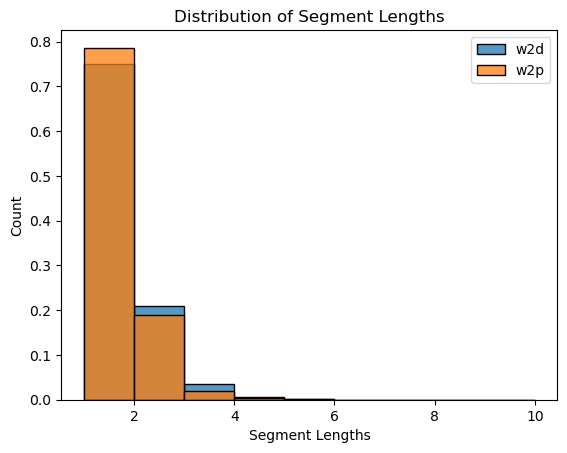

In [93]:
# Define the bins with uniform width
bins = np.arange(1, 11, 1)
sns.histplot(w2d_lens, bins=bins, label="w2d", stat='probability')
sns.histplot(w2p_lens, bins=bins, label="w2p", stat='probability')
plt.xlabel('Segment Lengths')
plt.ylabel('Count')
plt.title('Distribution of Segment Lengths')
plt.legend()
plt.show()

In [95]:
toleranceInFrames = 0
EPS = 1e-12

precision_hist = []
recall_hist = []
r_hist = []

for predictedBoundaries, trueBoundaries in zip(w2d_boundaries, w2p_boundaries):
    precisionCounter = 0
    recallCounter = 0

    for predictedBoundary in predictedBoundaries:
        minDist = torch.min(torch.abs(trueBoundaries - predictedBoundary))
        precisionCounter += (minDist <= toleranceInFrames)

    for trueBoundary in trueBoundaries:
        minDist = torch.min(torch.abs(predictedBoundaries - trueBoundary))
        detected = (minDist <= toleranceInFrames)
        recallCounter += detected

    precision = precisionCounter / (len(predictedBoundaries) + EPS)
    recall = recallCounter / (len(trueBoundaries) + EPS)
    f1 = 2 * (precision * recall) / (precision + recall + EPS)
    os = recall / (precision + EPS) - 1
    r1 = torch.sqrt((1 - recall) ** 2 + os ** 2)
    r2 = (-os + recall - 1) / (math.sqrt(2))
    rVal = 1 - (torch.abs(r1) + torch.abs(r2)) / 2
    
    precision_hist.append(precision.item())
    recall_hist.append(recall.item())
    r_hist.append(rVal.item())

In [96]:
print(np.mean(precision_hist))
print(np.mean(recall_hist)) 
print(np.mean(r_hist))

0.8123179326135072
0.7758581259628897
0.8146960155298565


In [8]:
loss_weights = []
epoch = 1
train_itr = get_batch_iterator('train', epoch)
features, padding_mask, aux_target, random_label = next(train_itr)["net_input"].values()  # fetch the very first batchs
iter_num = 0
wav2dyn.train()
optimizer = torch.optim.SGD(wav2dyn.parameters(), lr=0.0001)
while True:
    scaled_losses = {}
    res = wav2dyn(features.to(config["device"]), 
                  padding_mask.to(config["device"]), 
                  random_label.to(config["device"]),
                  aux_target=aux_target.to(config["device"]))
#     posteriograms = select_non_padding_elements(res["posteriogram"].contiguous(), 
#                                                 res["posteriogram_mask"].contiguous())
    losses = res["losses"]
    for lk, p in losses.items():
        try:
            coef = 1.0 if len(loss_weights) == 0 else loss_weights[lk]
        except KeyError:
            logger.error(
                f"weight for loss {lk} is not in loss_weights ({loss_weights})"
            )
            raise
        if coef != 0 and p is not None:
            scaled_losses[lk] = coef * p.float()
    loss = sum(scaled_losses.values())
    grad_smooth = autograd.grad(outputs=losses["smoothness"], inputs=res["posteriogram"], create_graph=False, retain_graph=False, only_inputs=True)
    grad_code_pen = autograd.grad(outputs=losses["code_pen"], inputs=res["posteriogram"], create_graph=False, retain_graph=True, only_inputs=True)
#     grad_grad_pen = autograd.grad(outputs=losses["grad_pen"], inputs=res["posteriogram"], create_graph=False, retain_graph=False, only_inputs=True)
    grad_mmi = autograd.grad(outputs=losses["mmi"], inputs=res["inter_x"], create_graph=False, retain_graph=False, only_inputs=True)
    grad_dense_g = autograd.grad(outputs=losses["dense_g"], inputs=res["posteriogram"], create_graph=False, retain_graph=False, only_inputs=True)
#     grad_dense_g = autograd.grad(outputs=losses["dense_g"], inputs=res["posteriogram"], create_graph=False, retain_graph=False, only_inputs=True)
    break
    iter_num += 1
    try:
        features, padding_mask, aux_target, random_label = next(train_itr)["net_input"].values()
    except StopIteration:
        break

# Let's do some training

In [10]:
# learning rate decay scheduler (cosine with warmup)
def get_lr(it, suff):
    # 1) linear warmup for warmup_iters steps
    if it < config[f"warmup_iters{suff}"]:
        return config[f"learning_rate{suff}"] * it / config[f"warmup_iters{suff}"]
    # 2) if it > lr_decay_iters, return min learning rate
    if it >= config["lr_decay_iters"]:
        return config[f"min_lr{suff}"]
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - config[f"warmup_iters{suff}"]) / (config["lr_decay_iters"] - config[f"warmup_iters{suff}"])
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return config[f"min_lr{suff}"] + coeff * (config[f"learning_rate{suff}"] - config[f"min_lr{suff}"])

In [6]:
# wandb.init(project='w2v-u-indy', name=f'frozen_w2d_disc-train_gen', entity='indy-lis', config=config)

os.makedirs(config["out_dir"], exist_ok=True)
optimizer = {
    "_d": torch.optim.Adam(wav2dyn.discriminator.parameters(), lr=config["learning_rate_d"], 
                             betas=(config["beta1_d"], config["beta2_d"]), 
                             eps=config["eps_d"], weight_decay=config["weight_decay_d"]),
    "_g": torch.optim.Adam(wav2dyn.generator.parameters(), lr=config["learning_rate_g"], 
                             betas=(config["beta1_g"], config["beta2_g"]), 
                             eps=config["eps_g"], weight_decay=config["weight_decay_g"])
}

iter_num = 0
epoch = 1
train_itr = get_batch_iterator('train', epoch)
features, padding_mask, random_label = next(train_itr)["net_input"].values()  # fetch the very first batchs
try:
    while True:
        turn = wav2dyn.get_groups_for_update(wav2dyn.update_num)
        suff = "_d" if turn == "discriminator" else "_g"
        lr = get_lr(iter_num, suff)
        for param_group in optimizer[suff].param_groups:
            param_group['lr'] = lr
        # --------------------------------------------------------------------------------------------------------
        posteriograms, padding_mask_post = wav2dyn(features.to(config["device"]), padding_mask.to(config["device"]), random_label.to(config["device"]), dense_x_only=True).values()
        posteriograms = posteriograms[:, :wav2dyn.block_size]
        c_embeddings, c_logits, predictograms, c_entropy = wav2dyn.gen_lm(posteriograms, return_posteriograms=True)
        padding_mask_post = padding_mask_post[:, :wav2dyn.block_size]
        disc_score = wav2dyn.discriminator(predictograms, padding_mask_post)
        loss = F.binary_cross_entropy_with_logits(disc_score, disc_score.new_zeros(disc_score.shape), reduction="sum")
        # --------------------------------------------------------------------------------------------------------\
        loss.backward()
        torch.nn.utils.clip_grad_norm_(wav2dyn.generator.parameters(), config["grad_clip"])
        optimizer[suff].step()
        optimizer[suff].zero_grad(set_to_none=True)
        if iter_num % config["log_interval"] == 0 or (iter_num + 1) % config["log_interval"] == 0:
            lossf = loss.item()
            print(f"iter {iter_num}: loss{suff} {lossf:.4f}")
#             wandb.log({
#                 "iter": iter_num,
#                 f"train/loss{suff}": lossf,
#                 f"lr{suff}": lr
#             })
        iter_num += 1
        wav2dyn.update_num = iter_num
        if iter_num > config["max_iters"]:
            break
        try:
            features, padding_mask, random_label = next(train_itr)["net_input"].values()
        except StopIteration:
            epoch += 1
            train_itr = get_batch_iterator('train', epoch)
            features, padding_mask, random_label = next(train_itr)["net_input"].values()
#     wandb.finish()
except KeyboardInterrupt:
#     wandb.finish()
    pass

iter 0: loss_g 212.5683
iter 9: loss_d 168.7998
iter 10: loss_g 330.2292
iter 19: loss_d 60.5106
iter 20: loss_g 269.0919
iter 29: loss_d 269.9656
iter 30: loss_g 271.4839
iter 39: loss_d 165.1410
iter 40: loss_g 229.6908
iter 49: loss_d 87.4388
iter 50: loss_g 93.6778
iter 59: loss_d 68.0183
iter 60: loss_g 186.6227
iter 69: loss_d 143.7158
iter 70: loss_g 195.6595
iter 79: loss_d 176.2274
iter 80: loss_g 22.2781
iter 89: loss_d 95.1678
iter 90: loss_g 218.0295
iter 99: loss_d 118.3011
iter 100: loss_g 209.9994


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3da84b5040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.9/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 1942699, 1942700) exited unexpectedly